In [1]:
import pandas as pd
import numpy as np
import joblib
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.metrics import Accuracy
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split


2025-05-28 02:47:02.182493: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748400422.437229      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748400422.510873      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
pd.set_option('display.max_rows', None)

In [3]:
param_dist = {
    'units': [32, 64, 128],              # số neuron mỗi layer
    'dropout': [0.2, 0.3, 0.5],          # dropout giữa các lớp
    'batch_size': [16, 32, 64],          # batch size khi huấn luyện
    'epochs': [10, 20, 30],              # số epoch huấn luyện
    'learning_rate': [0.001, 0.0005],    # tốc độ học
}


In [4]:
import os
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

def build_lstm_model(input_shape, num_classes, units=64, dropout=0.3):
    model = Sequential()
    model.add(LSTM(units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(units))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def train_phase(phase_path, random_state=42, sample=False, units=64, dropout=0.3, batch_size=32, epochs=30):
    best_model = None
    best_score = 0
    all_metrics = []
    best_fold = None

    for fold in range(1, 6):
        fold_path = os.path.join(phase_path, f"fold{fold}")
        scaler = joblib.load(f"{fold_path}/scaler.pkl")

        if sample:
            X_train = pd.read_csv(f"{fold_path}/X_train_resampled.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train_resampled.csv").values.ravel()
            X_train_scaled = X_train
        else:
            X_train = pd.read_csv(f"{fold_path}/X_train.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train.csv").values.ravel()
            X_train_scaled = scaler.transform(X_train)
            X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

        X_val = pd.read_csv(f"{fold_path}/X_val.csv")
        y_val = pd.read_csv(f"{fold_path}/y_val.csv").values.ravel()
        X_val_scaled = scaler.transform(X_val)
        X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_train.columns)

        # Reshape cho LSTM: (samples, timesteps=1, features)
        X_train_lstm = np.expand_dims(X_train_scaled.values, axis=1)
        X_val_lstm = np.expand_dims(X_val_scaled.values, axis=1)

        # Xử lý nhãn
        classes = np.unique(np.concatenate((y_train, y_val)))
        y_train_cat = to_categorical(np.searchsorted(classes, y_train), num_classes=len(classes))
        y_val_cat = to_categorical(np.searchsorted(classes, y_val), num_classes=len(classes))

        # Build model
        input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])
        model = build_lstm_model(input_shape, num_classes=len(classes), units=units, dropout=dropout)

        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        model.fit(
            X_train_lstm, y_train_cat,
            validation_data=(X_val_lstm, y_val_cat),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stop],
            verbose=2
        )

        # Predict
        y_proba = model.predict(X_val_lstm)
        y_pred = np.argmax(y_proba, axis=1)
        y_val_idx = np.searchsorted(classes, y_val)

        acc = accuracy_score(y_val_idx, y_pred)
        f1 = f1_score(y_val_idx, y_pred, average='macro')
        y_val_bin = label_binarize(y_val_idx, classes=range(len(classes)))
        auc = roc_auc_score(y_val_bin, y_proba, average='macro', multi_class='ovr')

        all_metrics.append({'fold': fold, 'accuracy': acc, 'f1_macro': f1, 'auc': auc})

        if f1 > best_score:
            best_score = f1
            best_model = model
            best_scaler = scaler
            best_fold = fold

        print(f"\nFold {fold} Classification Report:\n", classification_report(y_val_idx, y_pred))

        # Confusion Matrix
        cm = confusion_matrix(y_val_idx, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=classes, yticklabels=classes)
        plt.title(f'Confusion Matrix - Fold {fold}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

        # ROC Curves
        plt.figure(figsize=(8, 6))
        for i, cls in enumerate(classes):
            fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_proba[:, i])
            plt.plot(fpr, tpr, label=f'Class {cls}')
        plt.plot([0, 1], [0, 1], 'k--', label='Chance')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - Fold {fold}')
        plt.legend()
        plt.tight_layout()
        plt.show()

    # Average metrics
    avg_metrics = pd.DataFrame(all_metrics).mean().to_dict()
    print(f"\nAverage Accuracy: {avg_metrics['accuracy']:.4f}")
    print(f"Average F1 Macro: {avg_metrics['f1_macro']:.4f}")
    print(f"Average AUC: {avg_metrics['auc']:.4f}")

    return best_model, best_scaler, best_fold, all_metrics




======= Training Phase 1 ========



2025-05-28 02:47:19.740881: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
340/340 - 13s - 39ms/step - accuracy: 0.6558 - loss: 0.9872 - val_accuracy: 0.6575 - val_loss: 0.8329
Epoch 2/30
340/340 - 2s - 6ms/step - accuracy: 0.6594 - loss: 0.8452 - val_accuracy: 0.6593 - val_loss: 0.8107
Epoch 3/30
340/340 - 2s - 6ms/step - accuracy: 0.6665 - loss: 0.8221 - val_accuracy: 0.6744 - val_loss: 0.7894
Epoch 4/30
340/340 - 2s - 7ms/step - accuracy: 0.6799 - loss: 0.7959 - val_accuracy: 0.6888 - val_loss: 0.7741
Epoch 5/30
340/340 - 2s - 7ms/step - accuracy: 0.6859 - loss: 0.7735 - val_accuracy: 0.7002 - val_loss: 0.7504
Epoch 6/30
340/340 - 2s - 7ms/step - accuracy: 0.6937 - loss: 0.7666 - val_accuracy: 0.7020 - val_loss: 0.7448
Epoch 7/30
340/340 - 2s - 6ms/step - accuracy: 0.6963 - loss: 0.7584 - val_accuracy: 0.7002 - val_loss: 0.7365
Epoch 8/30
340/340 - 2s - 7ms/step - accuracy: 0.6968 - loss: 0.7509 - val_accuracy: 0.7017 - val_loss: 0.7332
Epoch 9/30
340/340 - 2s - 6ms/step - accuracy: 0.7021 - loss: 0.7428 - val_accuracy: 0.7061 - val_loss: 0.7294

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


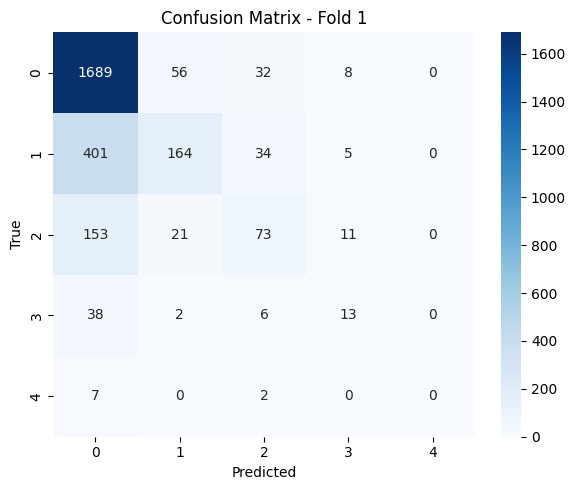

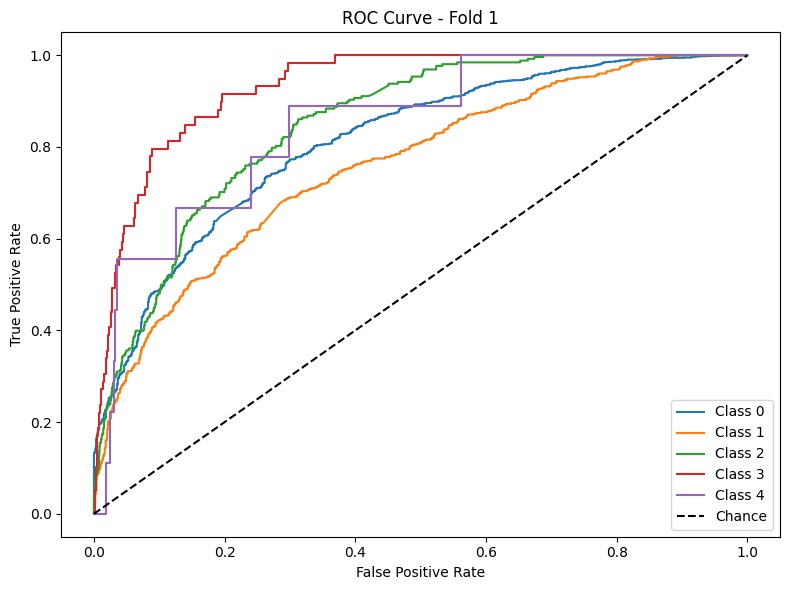

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


340/340 - 13s - 38ms/step - accuracy: 0.6562 - loss: 0.9794 - val_accuracy: 0.6581 - val_loss: 0.8593
Epoch 2/30
340/340 - 2s - 7ms/step - accuracy: 0.6603 - loss: 0.8371 - val_accuracy: 0.6592 - val_loss: 0.8410
Epoch 3/30
340/340 - 2s - 6ms/step - accuracy: 0.6675 - loss: 0.8160 - val_accuracy: 0.6857 - val_loss: 0.8090
Epoch 4/30
340/340 - 2s - 7ms/step - accuracy: 0.6797 - loss: 0.7932 - val_accuracy: 0.6916 - val_loss: 0.7911
Epoch 5/30
340/340 - 2s - 7ms/step - accuracy: 0.6923 - loss: 0.7705 - val_accuracy: 0.6898 - val_loss: 0.7683
Epoch 6/30
340/340 - 2s - 7ms/step - accuracy: 0.6954 - loss: 0.7571 - val_accuracy: 0.6960 - val_loss: 0.7645
Epoch 7/30
340/340 - 2s - 7ms/step - accuracy: 0.6942 - loss: 0.7569 - val_accuracy: 0.6990 - val_loss: 0.7593
Epoch 8/30
340/340 - 2s - 6ms/step - accuracy: 0.7038 - loss: 0.7460 - val_accuracy: 0.6912 - val_loss: 0.7701
Epoch 9/30
340/340 - 2s - 7ms/step - accuracy: 0.7032 - loss: 0.7454 - val_accuracy: 0.6945 - val_loss: 0.7489
Epoch 10/3

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


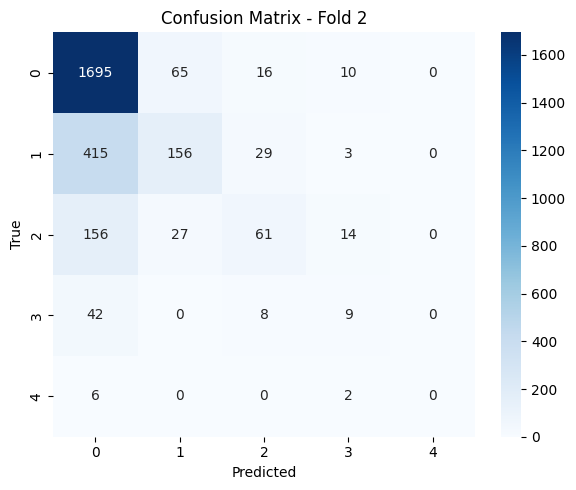

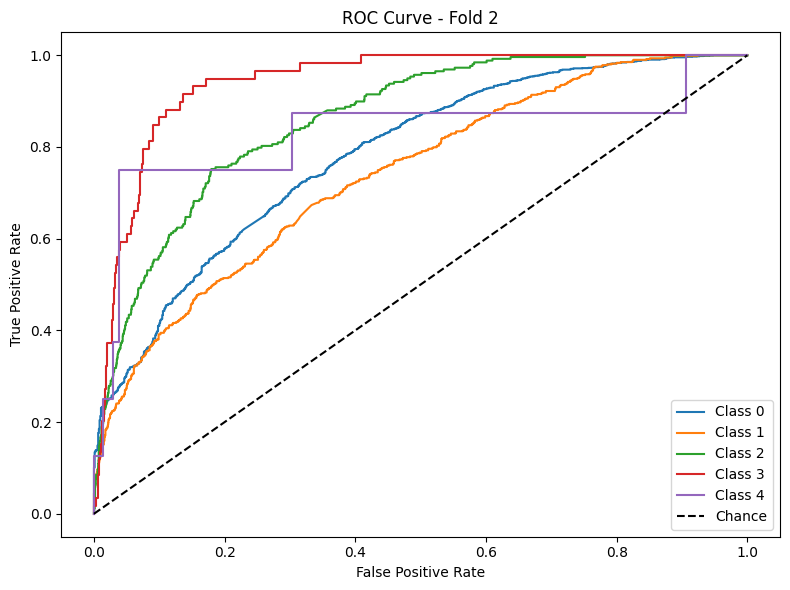

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


340/340 - 14s - 40ms/step - accuracy: 0.6552 - loss: 0.9918 - val_accuracy: 0.6581 - val_loss: 0.8343
Epoch 2/30
340/340 - 2s - 7ms/step - accuracy: 0.6608 - loss: 0.8392 - val_accuracy: 0.6684 - val_loss: 0.8103
Epoch 3/30
340/340 - 2s - 7ms/step - accuracy: 0.6729 - loss: 0.8204 - val_accuracy: 0.6783 - val_loss: 0.7852
Epoch 4/30
340/340 - 2s - 7ms/step - accuracy: 0.6828 - loss: 0.7928 - val_accuracy: 0.6927 - val_loss: 0.7718
Epoch 5/30
340/340 - 2s - 7ms/step - accuracy: 0.6889 - loss: 0.7770 - val_accuracy: 0.6986 - val_loss: 0.7587
Epoch 6/30
340/340 - 2s - 7ms/step - accuracy: 0.6955 - loss: 0.7702 - val_accuracy: 0.6960 - val_loss: 0.7487
Epoch 7/30
340/340 - 2s - 7ms/step - accuracy: 0.6926 - loss: 0.7601 - val_accuracy: 0.7008 - val_loss: 0.7421
Epoch 8/30
340/340 - 2s - 7ms/step - accuracy: 0.6986 - loss: 0.7521 - val_accuracy: 0.7019 - val_loss: 0.7323
Epoch 9/30
340/340 - 2s - 7ms/step - accuracy: 0.7039 - loss: 0.7427 - val_accuracy: 0.7012 - val_loss: 0.7292
Epoch 10/3

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


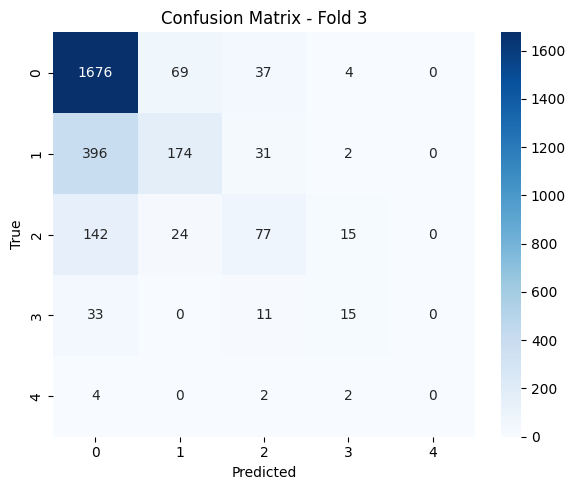

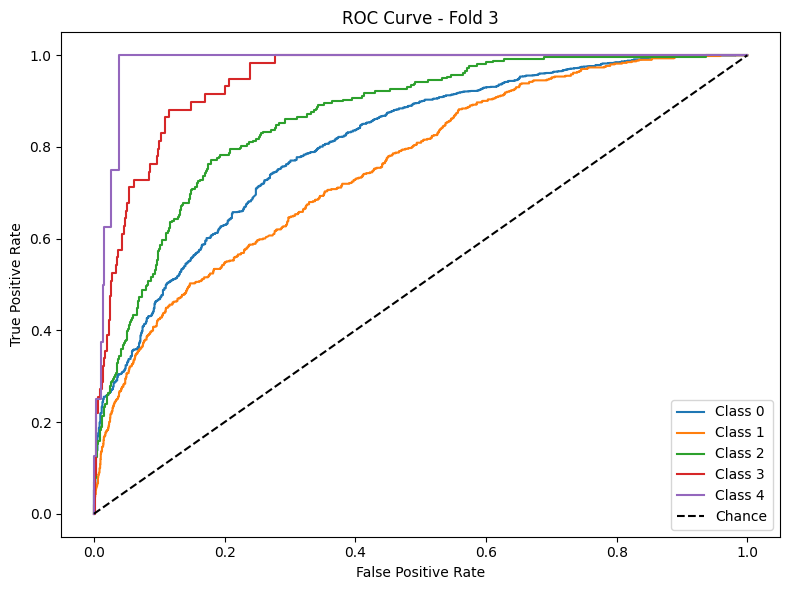

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


340/340 - 13s - 39ms/step - accuracy: 0.6565 - loss: 0.9917 - val_accuracy: 0.6577 - val_loss: 0.8451
Epoch 2/30
340/340 - 2s - 7ms/step - accuracy: 0.6580 - loss: 0.8429 - val_accuracy: 0.6588 - val_loss: 0.8121
Epoch 3/30
340/340 - 2s - 7ms/step - accuracy: 0.6645 - loss: 0.8197 - val_accuracy: 0.6824 - val_loss: 0.7786
Epoch 4/30
340/340 - 2s - 7ms/step - accuracy: 0.6773 - loss: 0.7980 - val_accuracy: 0.6835 - val_loss: 0.7613
Epoch 5/30
340/340 - 2s - 7ms/step - accuracy: 0.6815 - loss: 0.7823 - val_accuracy: 0.6805 - val_loss: 0.7601
Epoch 6/30
340/340 - 2s - 7ms/step - accuracy: 0.6884 - loss: 0.7694 - val_accuracy: 0.7063 - val_loss: 0.7350
Epoch 7/30
340/340 - 2s - 7ms/step - accuracy: 0.6930 - loss: 0.7596 - val_accuracy: 0.7133 - val_loss: 0.7266
Epoch 8/30
340/340 - 2s - 7ms/step - accuracy: 0.6937 - loss: 0.7555 - val_accuracy: 0.7192 - val_loss: 0.7235
Epoch 9/30
340/340 - 2s - 7ms/step - accuracy: 0.6958 - loss: 0.7494 - val_accuracy: 0.7178 - val_loss: 0.7180
Epoch 10/3

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


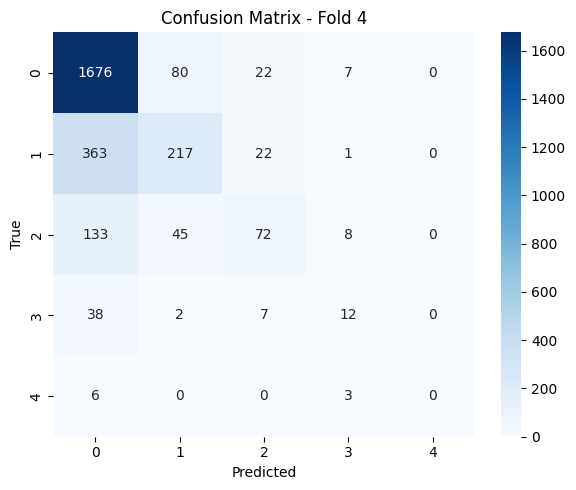

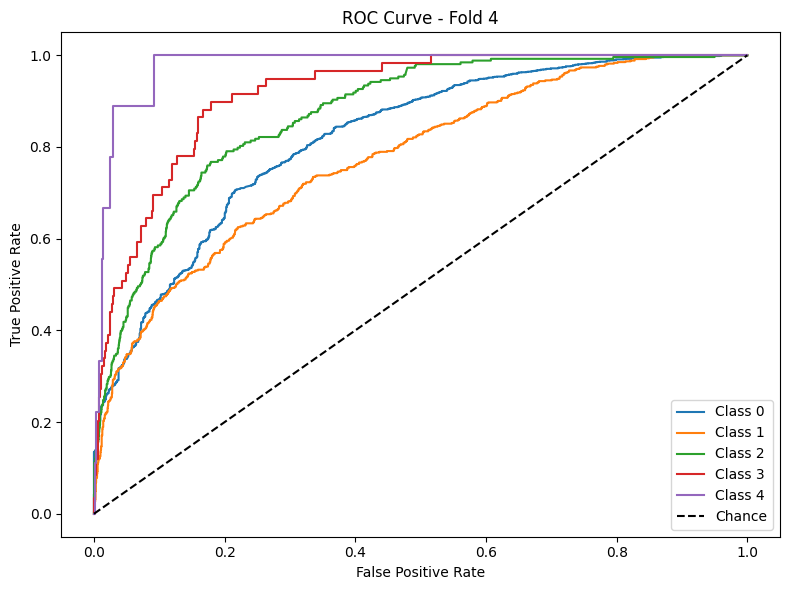

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


340/340 - 13s - 39ms/step - accuracy: 0.6561 - loss: 0.9849 - val_accuracy: 0.6577 - val_loss: 0.8350
Epoch 2/30
340/340 - 2s - 7ms/step - accuracy: 0.6587 - loss: 0.8379 - val_accuracy: 0.6603 - val_loss: 0.8160
Epoch 3/30
340/340 - 2s - 7ms/step - accuracy: 0.6610 - loss: 0.8255 - val_accuracy: 0.6647 - val_loss: 0.8109
Epoch 4/30
340/340 - 2s - 7ms/step - accuracy: 0.6658 - loss: 0.8119 - val_accuracy: 0.6684 - val_loss: 0.7886
Epoch 5/30
340/340 - 2s - 7ms/step - accuracy: 0.6797 - loss: 0.7858 - val_accuracy: 0.6945 - val_loss: 0.7673
Epoch 6/30
340/340 - 2s - 7ms/step - accuracy: 0.6896 - loss: 0.7711 - val_accuracy: 0.7001 - val_loss: 0.7530
Epoch 7/30
340/340 - 2s - 7ms/step - accuracy: 0.6998 - loss: 0.7546 - val_accuracy: 0.7012 - val_loss: 0.7447
Epoch 8/30
340/340 - 2s - 7ms/step - accuracy: 0.6980 - loss: 0.7562 - val_accuracy: 0.7115 - val_loss: 0.7384
Epoch 9/30
340/340 - 2s - 7ms/step - accuracy: 0.7019 - loss: 0.7431 - val_accuracy: 0.7071 - val_loss: 0.7370
Epoch 10/3

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


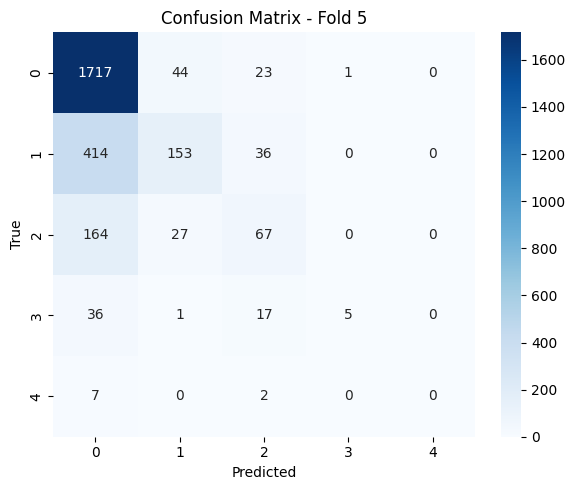

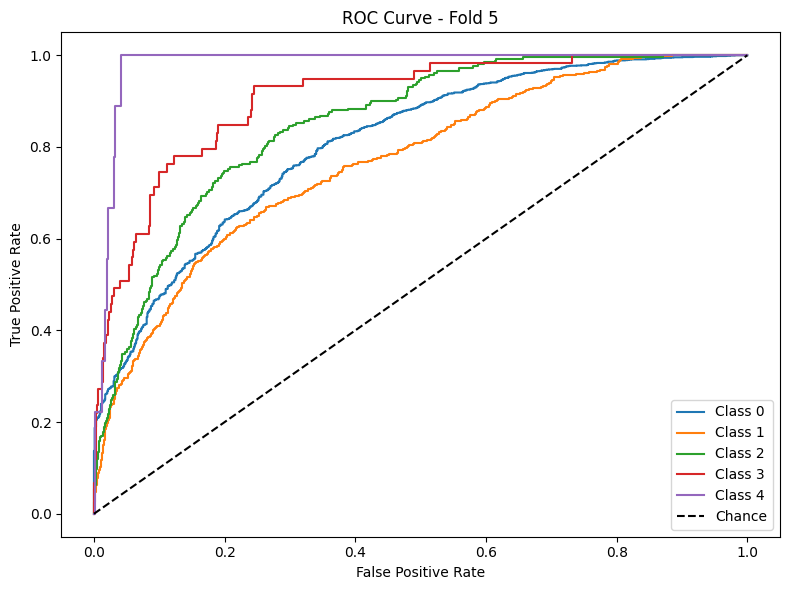


Average Accuracy: 0.7163
Average F1 Macro: 0.3638
Average AUC: 0.8551


======= Training Phase 2 ========

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


283/283 - 13s - 46ms/step - accuracy: 0.6574 - loss: 1.0102 - val_accuracy: 0.6597 - val_loss: 0.8605
Epoch 2/30
283/283 - 2s - 7ms/step - accuracy: 0.6606 - loss: 0.8494 - val_accuracy: 0.6602 - val_loss: 0.8266
Epoch 3/30
283/283 - 2s - 7ms/step - accuracy: 0.6637 - loss: 0.8318 - val_accuracy: 0.6615 - val_loss: 0.8197
Epoch 4/30
283/283 - 2s - 7ms/step - accuracy: 0.6655 - loss: 0.8118 - val_accuracy: 0.6606 - val_loss: 0.8124
Epoch 5/30
283/283 - 2s - 7ms/step - accuracy: 0.6727 - loss: 0.7973 - val_accuracy: 0.6748 - val_loss: 0.7838
Epoch 6/30
283/283 - 2s - 7ms/step - accuracy: 0.6821 - loss: 0.7847 - val_accuracy: 0.6796 - val_loss: 0.7731
Epoch 7/30
283/283 - 2s - 7ms/step - accuracy: 0.6830 - loss: 0.7734 - val_accuracy: 0.6845 - val_loss: 0.7726
Epoch 8/30
283/283 - 2s - 7ms/step - accuracy: 0.6912 - loss: 0.7610 - val_accuracy: 0.6854 - val_loss: 0.7563
Epoch 9/30
283/283 - 2s - 7ms/step - accuracy: 0.6929 - loss: 0.7564 - val_accuracy: 0.6898 - val_loss: 0.7569
Epoch 10/3

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


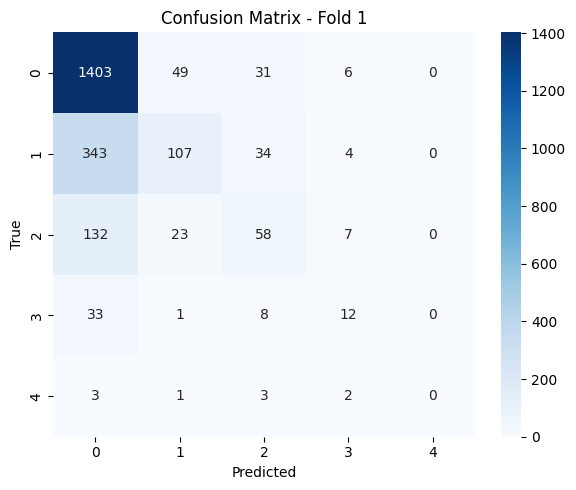

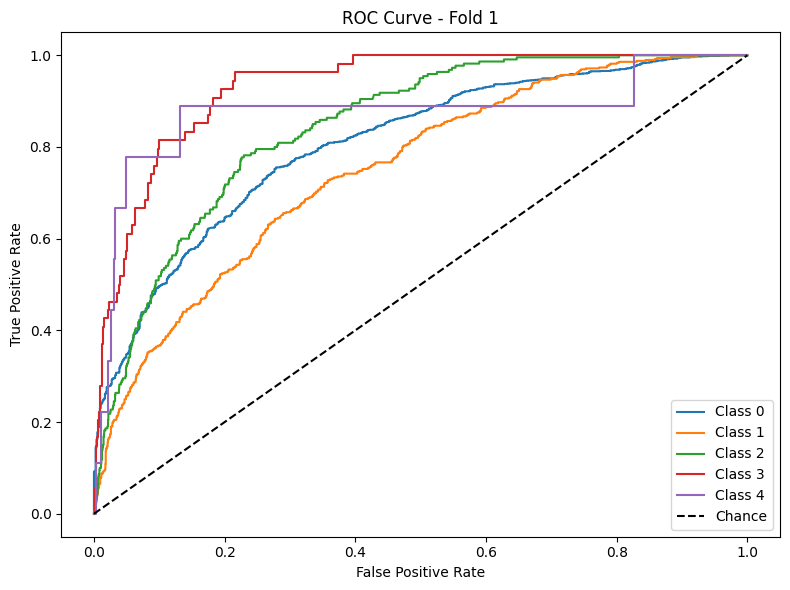

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


283/283 - 12s - 43ms/step - accuracy: 0.6570 - loss: 1.0107 - val_accuracy: 0.6588 - val_loss: 0.8481
Epoch 2/30
283/283 - 2s - 7ms/step - accuracy: 0.6597 - loss: 0.8510 - val_accuracy: 0.6642 - val_loss: 0.8178
Epoch 3/30
283/283 - 2s - 7ms/step - accuracy: 0.6615 - loss: 0.8342 - val_accuracy: 0.6637 - val_loss: 0.8026
Epoch 4/30
283/283 - 2s - 7ms/step - accuracy: 0.6640 - loss: 0.8182 - val_accuracy: 0.6681 - val_loss: 0.7983
Epoch 5/30
283/283 - 2s - 7ms/step - accuracy: 0.6650 - loss: 0.8097 - val_accuracy: 0.6673 - val_loss: 0.7879
Epoch 6/30
283/283 - 2s - 7ms/step - accuracy: 0.6757 - loss: 0.7919 - val_accuracy: 0.6903 - val_loss: 0.7629
Epoch 7/30
283/283 - 2s - 7ms/step - accuracy: 0.6846 - loss: 0.7749 - val_accuracy: 0.6969 - val_loss: 0.7586
Epoch 8/30
283/283 - 2s - 7ms/step - accuracy: 0.6873 - loss: 0.7676 - val_accuracy: 0.6947 - val_loss: 0.7491
Epoch 9/30
283/283 - 2s - 7ms/step - accuracy: 0.6948 - loss: 0.7584 - val_accuracy: 0.6987 - val_loss: 0.7482
Epoch 10/3

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


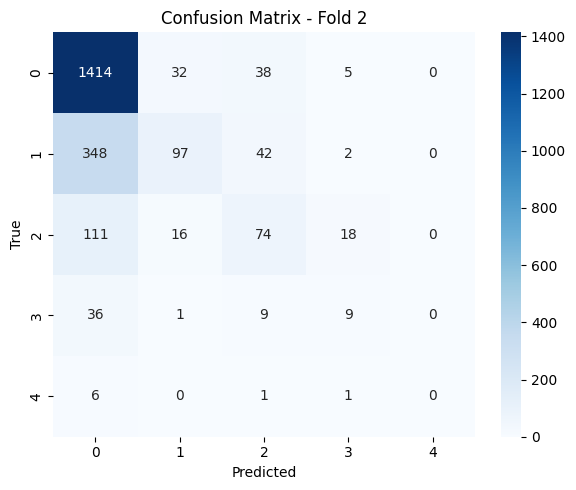

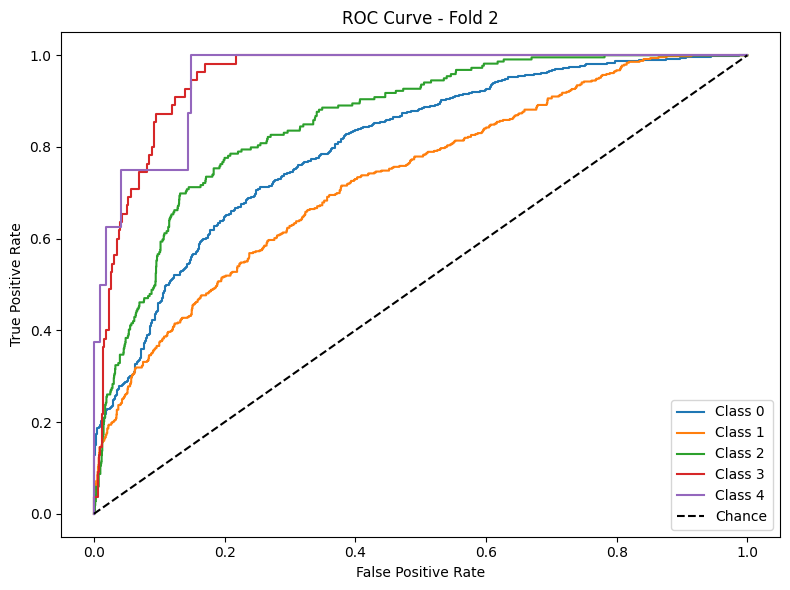

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


283/283 - 12s - 43ms/step - accuracy: 0.6562 - loss: 1.0021 - val_accuracy: 0.6622 - val_loss: 0.8569
Epoch 2/30
283/283 - 2s - 7ms/step - accuracy: 0.6613 - loss: 0.8549 - val_accuracy: 0.6614 - val_loss: 0.8370
Epoch 3/30
283/283 - 2s - 7ms/step - accuracy: 0.6617 - loss: 0.8286 - val_accuracy: 0.6609 - val_loss: 0.8172
Epoch 4/30
283/283 - 2s - 7ms/step - accuracy: 0.6636 - loss: 0.8189 - val_accuracy: 0.6605 - val_loss: 0.8078
Epoch 5/30
283/283 - 2s - 7ms/step - accuracy: 0.6642 - loss: 0.8076 - val_accuracy: 0.6609 - val_loss: 0.8023
Epoch 6/30
283/283 - 2s - 7ms/step - accuracy: 0.6653 - loss: 0.7971 - val_accuracy: 0.6622 - val_loss: 0.7858
Epoch 7/30
283/283 - 2s - 7ms/step - accuracy: 0.6716 - loss: 0.7867 - val_accuracy: 0.6835 - val_loss: 0.7740
Epoch 8/30
283/283 - 2s - 7ms/step - accuracy: 0.6851 - loss: 0.7700 - val_accuracy: 0.6919 - val_loss: 0.7562
Epoch 9/30
283/283 - 2s - 7ms/step - accuracy: 0.6912 - loss: 0.7570 - val_accuracy: 0.6817 - val_loss: 0.7549
Epoch 10/3

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


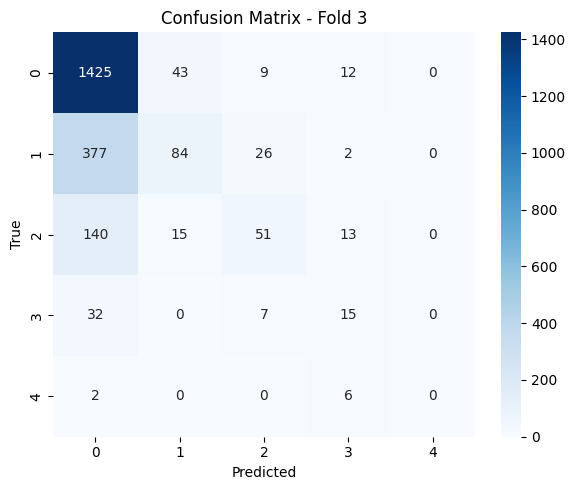

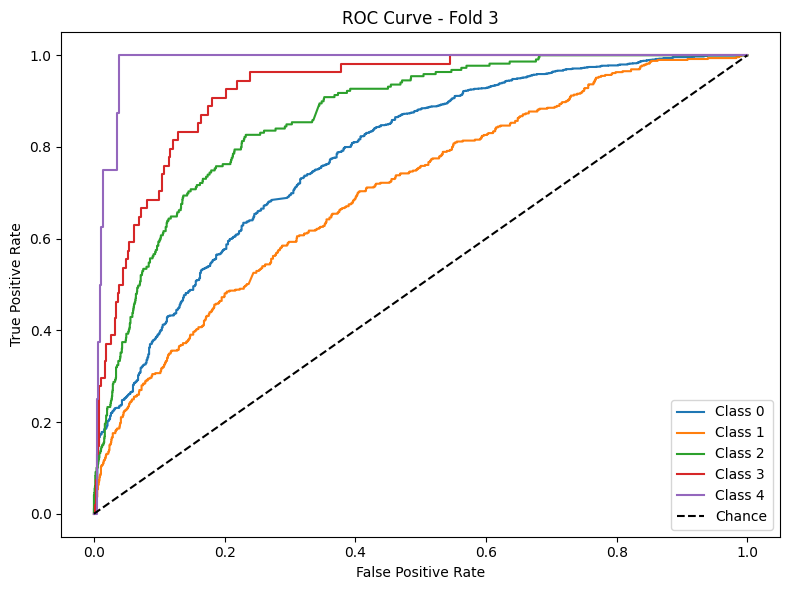

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


283/283 - 13s - 47ms/step - accuracy: 0.6567 - loss: 1.0084 - val_accuracy: 0.6596 - val_loss: 0.8568
Epoch 2/30
283/283 - 2s - 7ms/step - accuracy: 0.6598 - loss: 0.8440 - val_accuracy: 0.6605 - val_loss: 0.8334
Epoch 3/30
283/283 - 2s - 7ms/step - accuracy: 0.6659 - loss: 0.8279 - val_accuracy: 0.6636 - val_loss: 0.8239
Epoch 4/30
283/283 - 2s - 7ms/step - accuracy: 0.6687 - loss: 0.8101 - val_accuracy: 0.6702 - val_loss: 0.8147
Epoch 5/30
283/283 - 2s - 7ms/step - accuracy: 0.6732 - loss: 0.7969 - val_accuracy: 0.6715 - val_loss: 0.8121
Epoch 6/30
283/283 - 2s - 7ms/step - accuracy: 0.6850 - loss: 0.7763 - val_accuracy: 0.6910 - val_loss: 0.7705
Epoch 7/30
283/283 - 2s - 7ms/step - accuracy: 0.6877 - loss: 0.7662 - val_accuracy: 0.6941 - val_loss: 0.7616
Epoch 8/30
283/283 - 2s - 7ms/step - accuracy: 0.6915 - loss: 0.7536 - val_accuracy: 0.6919 - val_loss: 0.7522
Epoch 9/30
283/283 - 2s - 7ms/step - accuracy: 0.6955 - loss: 0.7508 - val_accuracy: 0.6937 - val_loss: 0.7472
Epoch 10/3

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


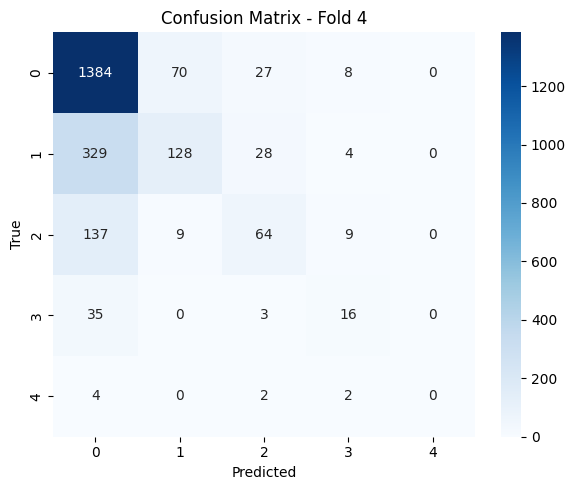

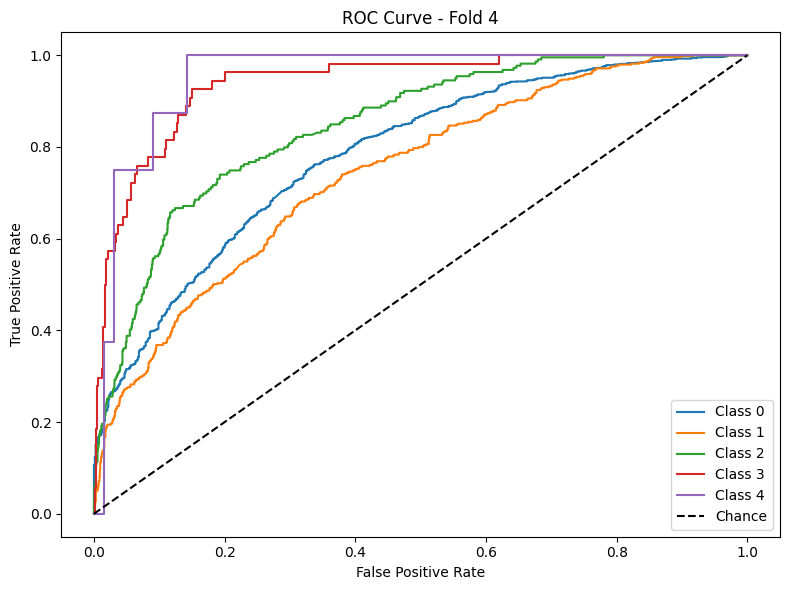

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


283/283 - 13s - 47ms/step - accuracy: 0.6568 - loss: 1.0141 - val_accuracy: 0.6596 - val_loss: 0.8470
Epoch 2/30
283/283 - 2s - 7ms/step - accuracy: 0.6602 - loss: 0.8549 - val_accuracy: 0.6609 - val_loss: 0.8189
Epoch 3/30
283/283 - 2s - 7ms/step - accuracy: 0.6619 - loss: 0.8372 - val_accuracy: 0.6636 - val_loss: 0.8047
Epoch 4/30
283/283 - 2s - 7ms/step - accuracy: 0.6639 - loss: 0.8191 - val_accuracy: 0.6636 - val_loss: 0.7915
Epoch 5/30
283/283 - 2s - 7ms/step - accuracy: 0.6719 - loss: 0.7980 - val_accuracy: 0.6870 - val_loss: 0.7776
Epoch 6/30
283/283 - 2s - 7ms/step - accuracy: 0.6800 - loss: 0.7806 - val_accuracy: 0.6892 - val_loss: 0.7573
Epoch 7/30
283/283 - 2s - 7ms/step - accuracy: 0.6859 - loss: 0.7704 - val_accuracy: 0.6946 - val_loss: 0.7517
Epoch 8/30
283/283 - 2s - 7ms/step - accuracy: 0.6892 - loss: 0.7606 - val_accuracy: 0.6932 - val_loss: 0.7440
Epoch 9/30
283/283 - 2s - 7ms/step - accuracy: 0.6940 - loss: 0.7541 - val_accuracy: 0.7012 - val_loss: 0.7370
Epoch 10/3

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


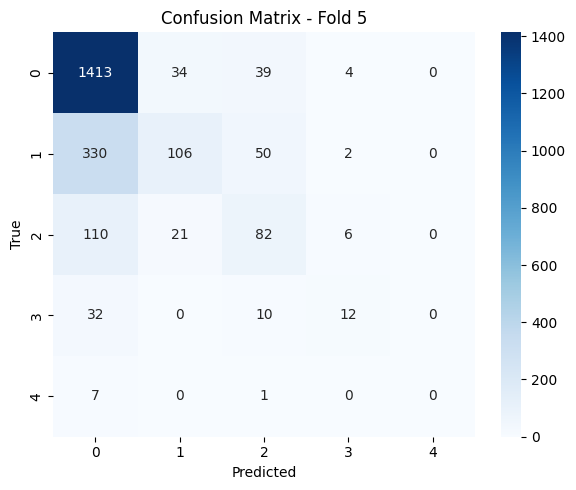

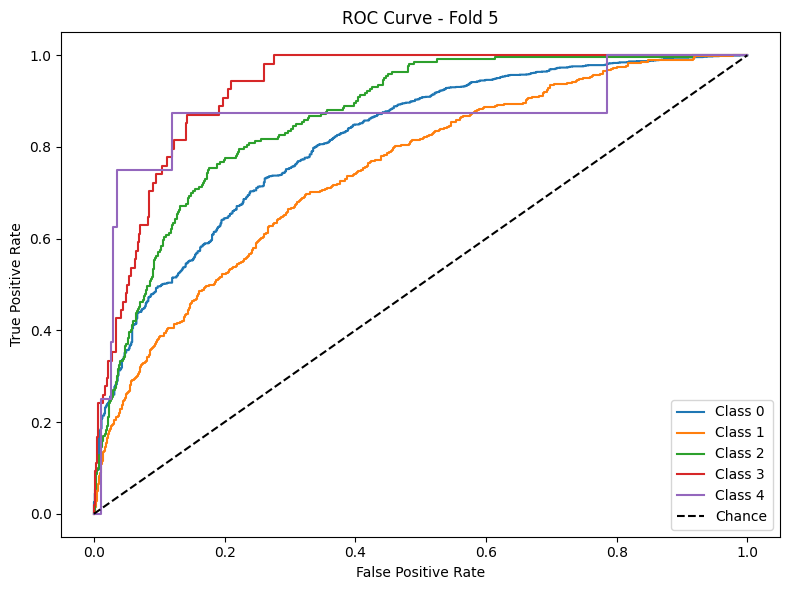


Average Accuracy: 0.7041
Average F1 Macro: 0.3588
Average AUC: 0.8501


======= Training Phase 3 ========

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


260/260 - 13s - 51ms/step - accuracy: 0.6544 - loss: 1.0304 - val_accuracy: 0.6557 - val_loss: 0.8587
Epoch 2/30
260/260 - 2s - 7ms/step - accuracy: 0.6556 - loss: 0.8615 - val_accuracy: 0.6567 - val_loss: 0.8221
Epoch 3/30
260/260 - 2s - 7ms/step - accuracy: 0.6574 - loss: 0.8380 - val_accuracy: 0.6654 - val_loss: 0.8094
Epoch 4/30
260/260 - 2s - 7ms/step - accuracy: 0.6633 - loss: 0.8198 - val_accuracy: 0.6663 - val_loss: 0.7894
Epoch 5/30
260/260 - 2s - 7ms/step - accuracy: 0.6710 - loss: 0.7975 - val_accuracy: 0.6929 - val_loss: 0.7649
Epoch 6/30
260/260 - 2s - 7ms/step - accuracy: 0.6863 - loss: 0.7776 - val_accuracy: 0.7035 - val_loss: 0.7448
Epoch 7/30
260/260 - 2s - 7ms/step - accuracy: 0.6880 - loss: 0.7684 - val_accuracy: 0.6967 - val_loss: 0.7507
Epoch 8/30
260/260 - 2s - 7ms/step - accuracy: 0.6911 - loss: 0.7556 - val_accuracy: 0.7015 - val_loss: 0.7339
Epoch 9/30
260/260 - 2s - 7ms/step - accuracy: 0.6981 - loss: 0.7447 - val_accuracy: 0.7035 - val_loss: 0.7320
Epoch 10/3

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


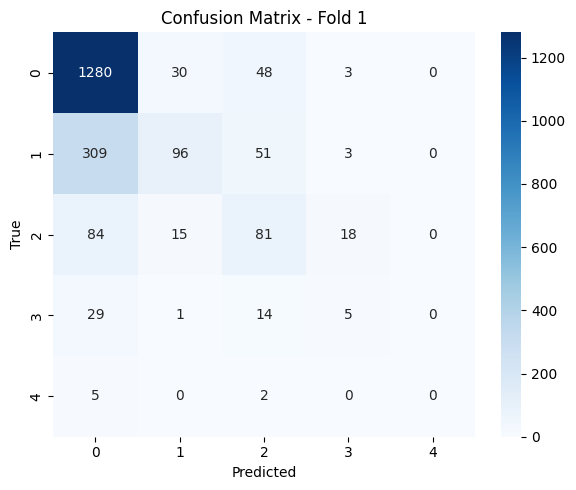

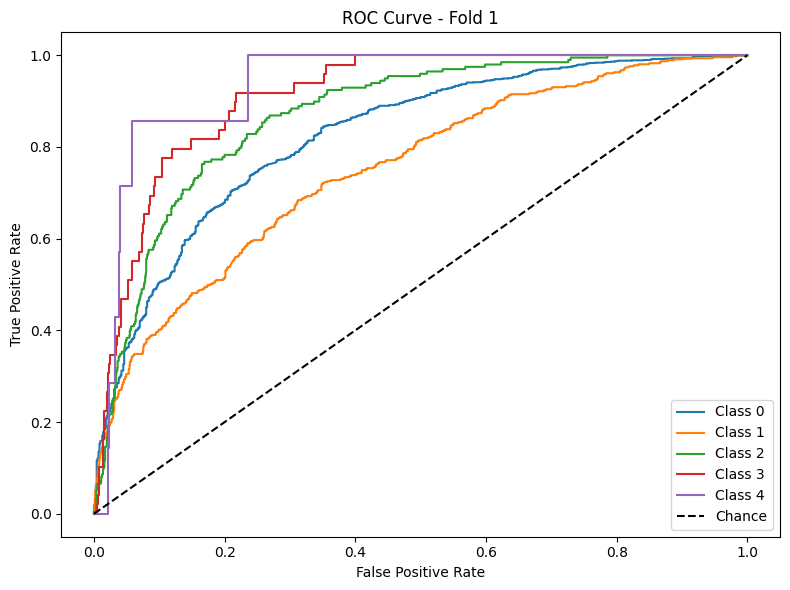

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


260/260 - 13s - 51ms/step - accuracy: 0.6538 - loss: 1.0364 - val_accuracy: 0.6567 - val_loss: 0.8561
Epoch 2/30
260/260 - 2s - 7ms/step - accuracy: 0.6568 - loss: 0.8578 - val_accuracy: 0.6567 - val_loss: 0.8227
Epoch 3/30
260/260 - 2s - 7ms/step - accuracy: 0.6579 - loss: 0.8362 - val_accuracy: 0.6553 - val_loss: 0.8082
Epoch 4/30
260/260 - 2s - 7ms/step - accuracy: 0.6614 - loss: 0.8210 - val_accuracy: 0.6557 - val_loss: 0.8006
Epoch 5/30
260/260 - 2s - 7ms/step - accuracy: 0.6676 - loss: 0.8053 - val_accuracy: 0.6924 - val_loss: 0.7812
Epoch 6/30
260/260 - 2s - 7ms/step - accuracy: 0.6855 - loss: 0.7862 - val_accuracy: 0.6798 - val_loss: 0.7660
Epoch 7/30
260/260 - 2s - 7ms/step - accuracy: 0.6867 - loss: 0.7720 - val_accuracy: 0.6938 - val_loss: 0.7585
Epoch 8/30
260/260 - 2s - 7ms/step - accuracy: 0.6884 - loss: 0.7597 - val_accuracy: 0.7044 - val_loss: 0.7499
Epoch 9/30
260/260 - 2s - 7ms/step - accuracy: 0.7001 - loss: 0.7449 - val_accuracy: 0.6958 - val_loss: 0.7394
Epoch 10/3

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


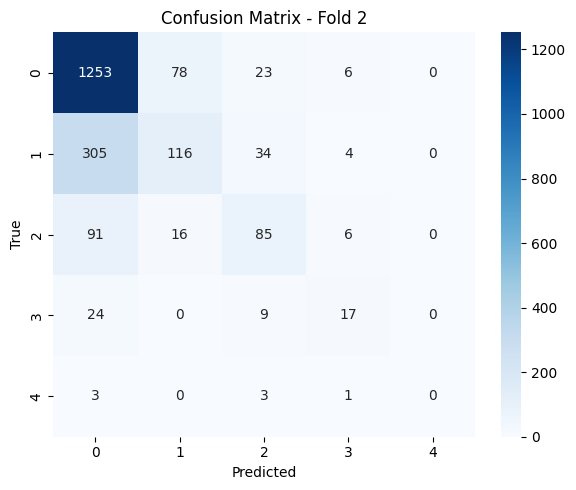

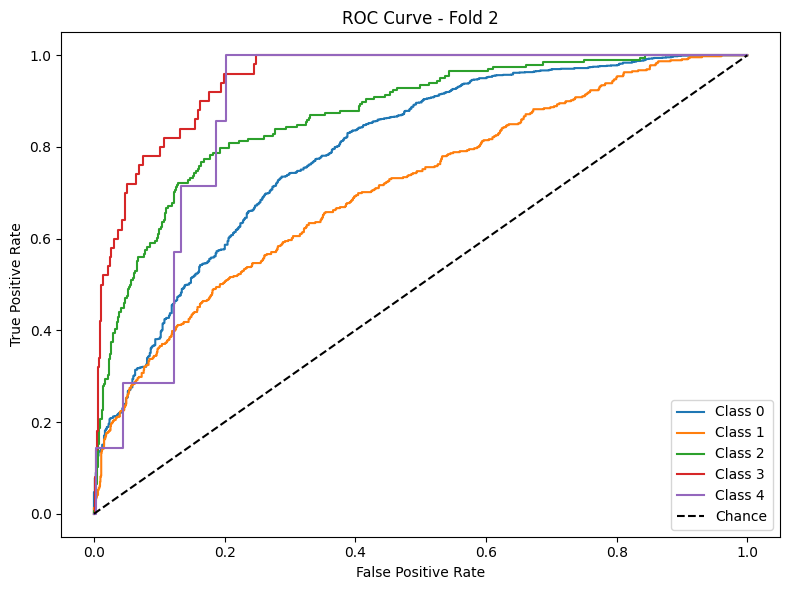

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


260/260 - 12s - 46ms/step - accuracy: 0.6532 - loss: 1.0430 - val_accuracy: 0.6557 - val_loss: 0.8643
Epoch 2/30
260/260 - 2s - 7ms/step - accuracy: 0.6569 - loss: 0.8590 - val_accuracy: 0.6596 - val_loss: 0.8324
Epoch 3/30
260/260 - 2s - 7ms/step - accuracy: 0.6606 - loss: 0.8355 - val_accuracy: 0.6601 - val_loss: 0.8207
Epoch 4/30
260/260 - 2s - 7ms/step - accuracy: 0.6624 - loss: 0.8196 - val_accuracy: 0.6659 - val_loss: 0.8127
Epoch 5/30
260/260 - 2s - 7ms/step - accuracy: 0.6643 - loss: 0.8115 - val_accuracy: 0.6663 - val_loss: 0.8024
Epoch 6/30
260/260 - 2s - 7ms/step - accuracy: 0.6720 - loss: 0.7972 - val_accuracy: 0.6716 - val_loss: 0.7798
Epoch 7/30
260/260 - 2s - 7ms/step - accuracy: 0.6799 - loss: 0.7794 - val_accuracy: 0.6890 - val_loss: 0.7613
Epoch 8/30
260/260 - 2s - 7ms/step - accuracy: 0.6909 - loss: 0.7624 - val_accuracy: 0.6929 - val_loss: 0.7501
Epoch 9/30
260/260 - 2s - 7ms/step - accuracy: 0.6945 - loss: 0.7544 - val_accuracy: 0.7054 - val_loss: 0.7475
Epoch 10/3

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


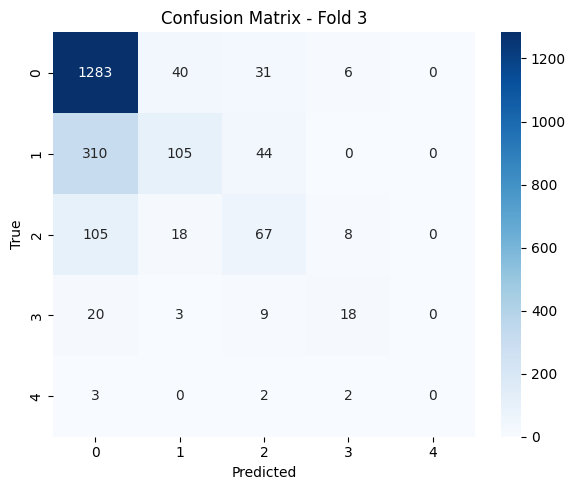

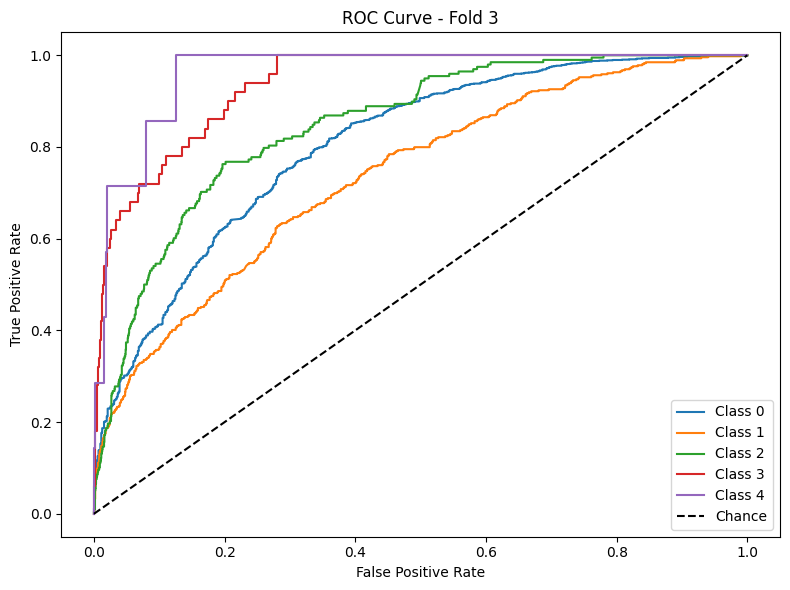

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


260/260 - 14s - 52ms/step - accuracy: 0.6538 - loss: 1.0302 - val_accuracy: 0.6572 - val_loss: 0.8692
Epoch 2/30
260/260 - 2s - 7ms/step - accuracy: 0.6569 - loss: 0.8598 - val_accuracy: 0.6557 - val_loss: 0.8425
Epoch 3/30
260/260 - 2s - 7ms/step - accuracy: 0.6590 - loss: 0.8304 - val_accuracy: 0.6567 - val_loss: 0.8364
Epoch 4/30
260/260 - 2s - 7ms/step - accuracy: 0.6633 - loss: 0.8144 - val_accuracy: 0.6644 - val_loss: 0.8247
Epoch 5/30
260/260 - 2s - 7ms/step - accuracy: 0.6653 - loss: 0.8091 - val_accuracy: 0.6673 - val_loss: 0.8256
Epoch 6/30
260/260 - 2s - 8ms/step - accuracy: 0.6727 - loss: 0.7952 - val_accuracy: 0.6707 - val_loss: 0.7996
Epoch 7/30
260/260 - 2s - 7ms/step - accuracy: 0.6850 - loss: 0.7761 - val_accuracy: 0.6861 - val_loss: 0.7886
Epoch 8/30
260/260 - 2s - 7ms/step - accuracy: 0.6926 - loss: 0.7589 - val_accuracy: 0.7006 - val_loss: 0.7718
Epoch 9/30
260/260 - 2s - 7ms/step - accuracy: 0.6976 - loss: 0.7493 - val_accuracy: 0.6871 - val_loss: 0.7653
Epoch 10/3

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


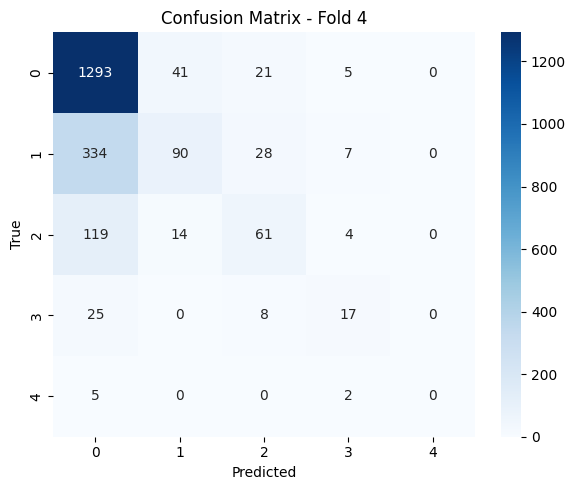

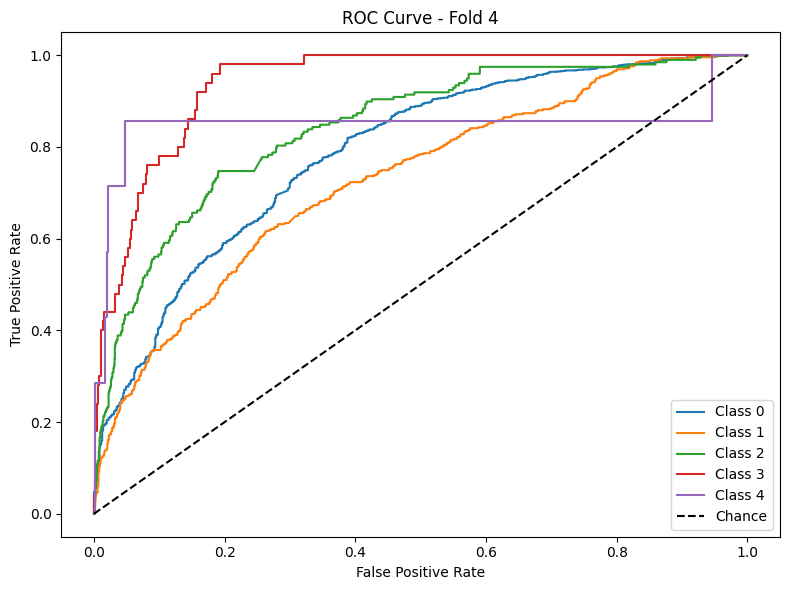

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


260/260 - 14s - 52ms/step - accuracy: 0.6538 - loss: 1.0269 - val_accuracy: 0.6551 - val_loss: 0.8784
Epoch 2/30
260/260 - 2s - 7ms/step - accuracy: 0.6557 - loss: 0.8623 - val_accuracy: 0.6561 - val_loss: 0.8469
Epoch 3/30
260/260 - 2s - 7ms/step - accuracy: 0.6586 - loss: 0.8288 - val_accuracy: 0.6541 - val_loss: 0.8371
Epoch 4/30
260/260 - 2s - 7ms/step - accuracy: 0.6636 - loss: 0.8140 - val_accuracy: 0.6633 - val_loss: 0.8165
Epoch 5/30
260/260 - 2s - 7ms/step - accuracy: 0.6679 - loss: 0.8018 - val_accuracy: 0.6594 - val_loss: 0.8082
Epoch 6/30
260/260 - 2s - 7ms/step - accuracy: 0.6801 - loss: 0.7806 - val_accuracy: 0.6744 - val_loss: 0.7966
Epoch 7/30
260/260 - 2s - 7ms/step - accuracy: 0.6874 - loss: 0.7722 - val_accuracy: 0.6744 - val_loss: 0.7831
Epoch 8/30
260/260 - 2s - 7ms/step - accuracy: 0.6926 - loss: 0.7575 - val_accuracy: 0.6802 - val_loss: 0.7840
Epoch 9/30
260/260 - 2s - 7ms/step - accuracy: 0.7002 - loss: 0.7458 - val_accuracy: 0.6802 - val_loss: 0.7721
Epoch 10/3

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


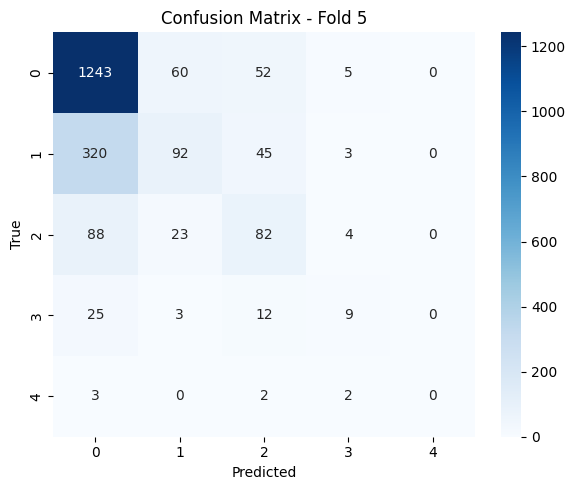

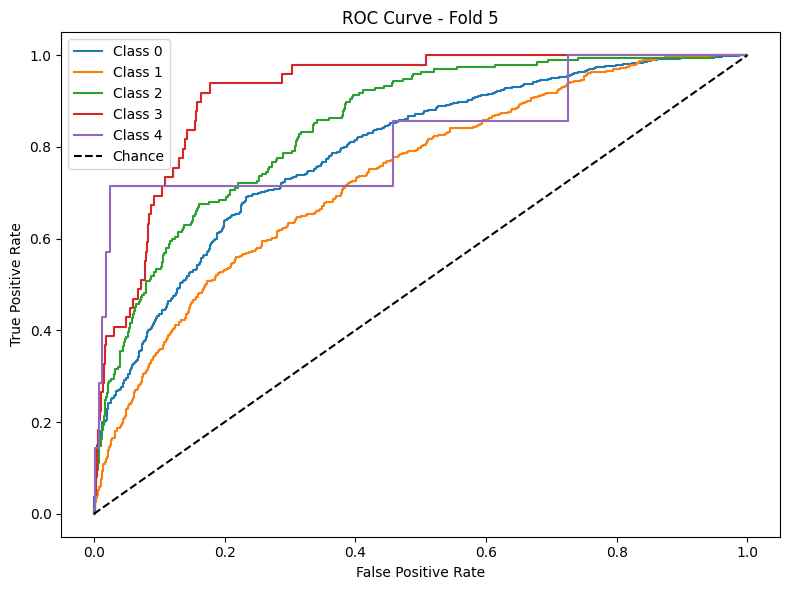


Average Accuracy: 0.7033
Average F1 Macro: 0.3767
Average AUC: 0.8416


======= Training Phase 4 ========

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


193/193 - 12s - 60ms/step - accuracy: 0.6474 - loss: 1.0824 - val_accuracy: 0.6498 - val_loss: 0.8816
Epoch 2/30
193/193 - 1s - 7ms/step - accuracy: 0.6506 - loss: 0.8704 - val_accuracy: 0.6491 - val_loss: 0.8519
Epoch 3/30
193/193 - 1s - 7ms/step - accuracy: 0.6516 - loss: 0.8383 - val_accuracy: 0.6517 - val_loss: 0.8262
Epoch 4/30
193/193 - 1s - 7ms/step - accuracy: 0.6513 - loss: 0.8260 - val_accuracy: 0.6504 - val_loss: 0.8177
Epoch 5/30
193/193 - 1s - 7ms/step - accuracy: 0.6527 - loss: 0.8145 - val_accuracy: 0.6485 - val_loss: 0.8083
Epoch 6/30
193/193 - 1s - 7ms/step - accuracy: 0.6594 - loss: 0.8046 - val_accuracy: 0.6569 - val_loss: 0.8020
Epoch 7/30
193/193 - 1s - 7ms/step - accuracy: 0.6714 - loss: 0.7892 - val_accuracy: 0.6680 - val_loss: 0.8007
Epoch 8/30
193/193 - 1s - 7ms/step - accuracy: 0.6880 - loss: 0.7703 - val_accuracy: 0.6823 - val_loss: 0.7794
Epoch 9/30
193/193 - 1s - 7ms/step - accuracy: 0.6997 - loss: 0.7565 - val_accuracy: 0.6823 - val_loss: 0.7712
Epoch 10/3

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


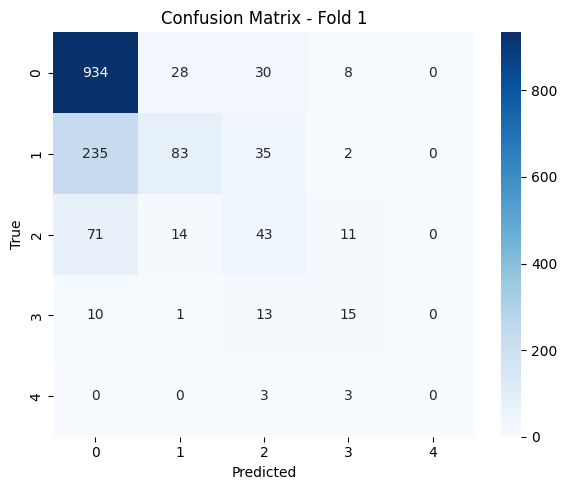

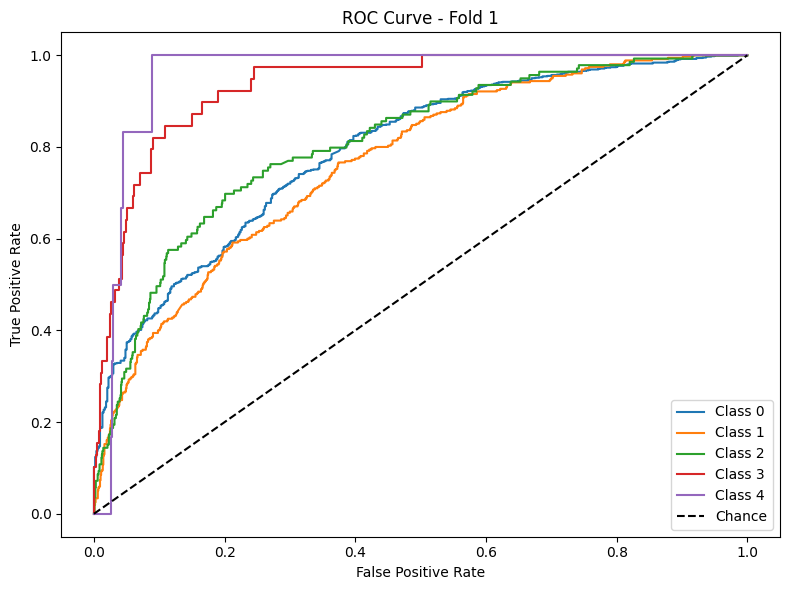

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


193/193 - 14s - 70ms/step - accuracy: 0.6462 - loss: 1.0767 - val_accuracy: 0.6498 - val_loss: 0.8781
Epoch 2/30
193/193 - 1s - 7ms/step - accuracy: 0.6487 - loss: 0.8717 - val_accuracy: 0.6524 - val_loss: 0.8415
Epoch 3/30
193/193 - 1s - 7ms/step - accuracy: 0.6508 - loss: 0.8365 - val_accuracy: 0.6498 - val_loss: 0.8342
Epoch 4/30
193/193 - 1s - 7ms/step - accuracy: 0.6557 - loss: 0.8230 - val_accuracy: 0.6524 - val_loss: 0.8210
Epoch 5/30
193/193 - 1s - 7ms/step - accuracy: 0.6625 - loss: 0.8042 - val_accuracy: 0.6582 - val_loss: 0.8107
Epoch 6/30
193/193 - 1s - 7ms/step - accuracy: 0.6731 - loss: 0.7874 - val_accuracy: 0.6764 - val_loss: 0.7861
Epoch 7/30
193/193 - 1s - 8ms/step - accuracy: 0.6830 - loss: 0.7691 - val_accuracy: 0.6810 - val_loss: 0.7768
Epoch 8/30
193/193 - 1s - 7ms/step - accuracy: 0.6878 - loss: 0.7573 - val_accuracy: 0.6940 - val_loss: 0.7625
Epoch 9/30
193/193 - 1s - 7ms/step - accuracy: 0.6955 - loss: 0.7406 - val_accuracy: 0.7018 - val_loss: 0.7600
Epoch 10/3

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


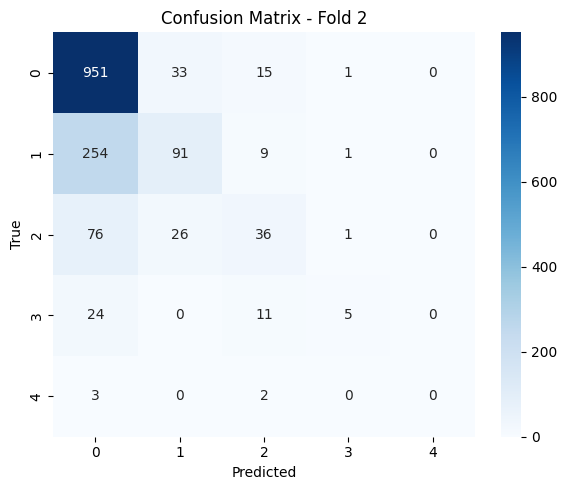

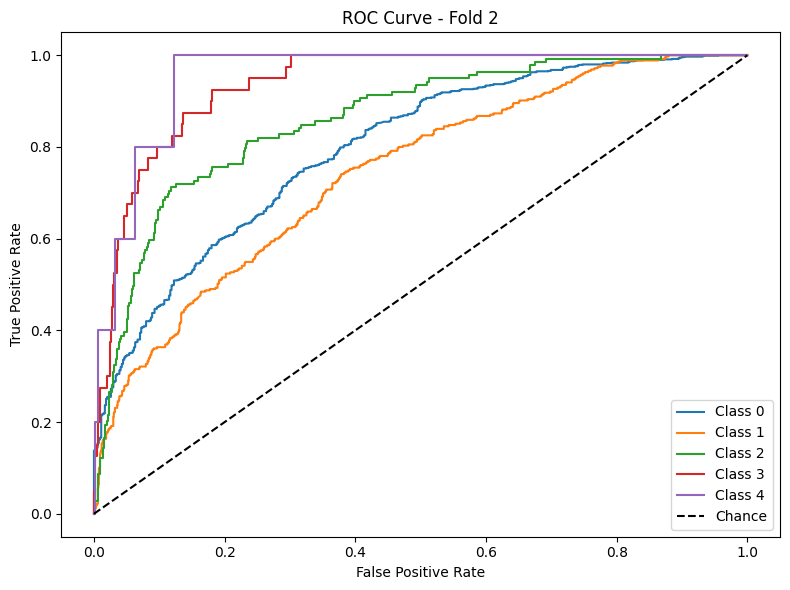

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


193/193 - 12s - 60ms/step - accuracy: 0.6462 - loss: 1.0818 - val_accuracy: 0.6491 - val_loss: 0.8950
Epoch 2/30
193/193 - 1s - 7ms/step - accuracy: 0.6497 - loss: 0.8711 - val_accuracy: 0.6491 - val_loss: 0.8569
Epoch 3/30
193/193 - 1s - 7ms/step - accuracy: 0.6511 - loss: 0.8481 - val_accuracy: 0.6550 - val_loss: 0.8409
Epoch 4/30
193/193 - 1s - 7ms/step - accuracy: 0.6521 - loss: 0.8329 - val_accuracy: 0.6602 - val_loss: 0.8269
Epoch 5/30
193/193 - 1s - 7ms/step - accuracy: 0.6635 - loss: 0.8129 - val_accuracy: 0.6628 - val_loss: 0.8280
Epoch 6/30
193/193 - 1s - 7ms/step - accuracy: 0.6836 - loss: 0.7907 - val_accuracy: 0.6823 - val_loss: 0.7874
Epoch 7/30
193/193 - 1s - 7ms/step - accuracy: 0.6830 - loss: 0.7725 - val_accuracy: 0.6875 - val_loss: 0.7646
Epoch 8/30
193/193 - 1s - 7ms/step - accuracy: 0.6909 - loss: 0.7485 - val_accuracy: 0.6810 - val_loss: 0.7657
Epoch 9/30
193/193 - 1s - 7ms/step - accuracy: 0.6937 - loss: 0.7420 - val_accuracy: 0.6959 - val_loss: 0.7490
Epoch 10/3

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


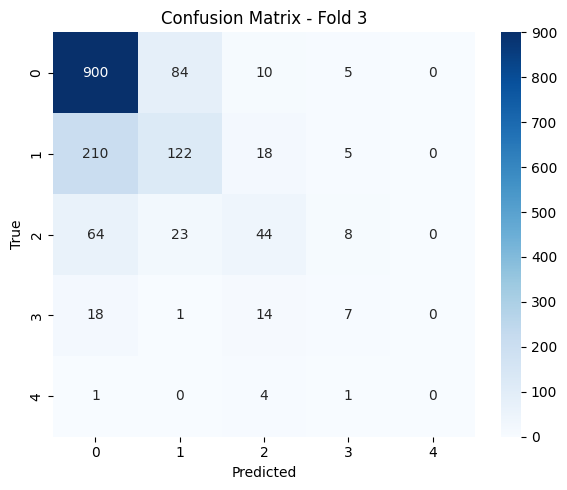

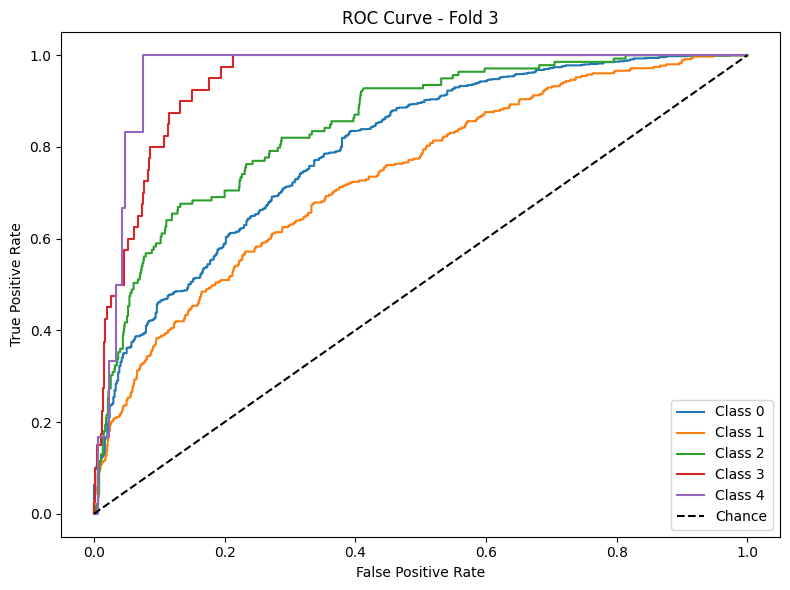

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


193/193 - 14s - 71ms/step - accuracy: 0.6463 - loss: 1.0844 - val_accuracy: 0.6495 - val_loss: 0.8839
Epoch 2/30
193/193 - 1s - 7ms/step - accuracy: 0.6487 - loss: 0.8682 - val_accuracy: 0.6495 - val_loss: 0.8450
Epoch 3/30
193/193 - 1s - 7ms/step - accuracy: 0.6509 - loss: 0.8427 - val_accuracy: 0.6534 - val_loss: 0.8242
Epoch 4/30
193/193 - 1s - 7ms/step - accuracy: 0.6528 - loss: 0.8247 - val_accuracy: 0.6541 - val_loss: 0.8156
Epoch 5/30
193/193 - 1s - 7ms/step - accuracy: 0.6546 - loss: 0.8135 - val_accuracy: 0.6547 - val_loss: 0.8014
Epoch 6/30
193/193 - 1s - 7ms/step - accuracy: 0.6614 - loss: 0.7991 - val_accuracy: 0.6541 - val_loss: 0.7940
Epoch 7/30
193/193 - 1s - 7ms/step - accuracy: 0.6817 - loss: 0.7776 - val_accuracy: 0.6840 - val_loss: 0.7842
Epoch 8/30
193/193 - 1s - 7ms/step - accuracy: 0.6929 - loss: 0.7585 - val_accuracy: 0.6931 - val_loss: 0.7641
Epoch 9/30
193/193 - 1s - 7ms/step - accuracy: 0.7037 - loss: 0.7448 - val_accuracy: 0.6951 - val_loss: 0.7866
Epoch 10/3

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


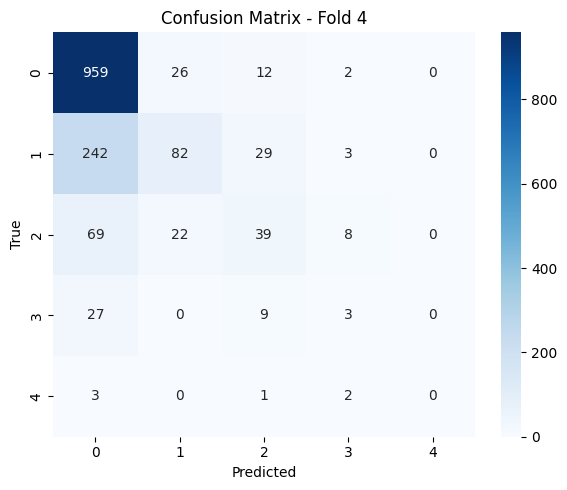

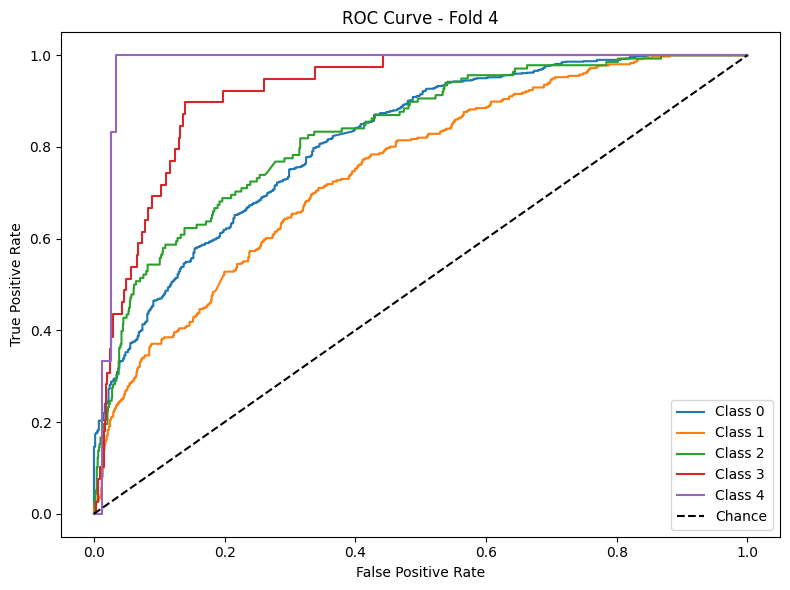

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


193/193 - 12s - 60ms/step - accuracy: 0.6466 - loss: 1.0839 - val_accuracy: 0.6495 - val_loss: 0.8786
Epoch 2/30
193/193 - 1s - 7ms/step - accuracy: 0.6489 - loss: 0.8760 - val_accuracy: 0.6482 - val_loss: 0.8451
Epoch 3/30
193/193 - 1s - 7ms/step - accuracy: 0.6505 - loss: 0.8424 - val_accuracy: 0.6528 - val_loss: 0.8115
Epoch 4/30
193/193 - 1s - 7ms/step - accuracy: 0.6647 - loss: 0.8186 - val_accuracy: 0.6814 - val_loss: 0.8010
Epoch 5/30
193/193 - 1s - 7ms/step - accuracy: 0.6768 - loss: 0.7938 - val_accuracy: 0.6834 - val_loss: 0.7797
Epoch 6/30
193/193 - 1s - 7ms/step - accuracy: 0.6754 - loss: 0.7822 - val_accuracy: 0.6938 - val_loss: 0.7596
Epoch 7/30
193/193 - 1s - 7ms/step - accuracy: 0.6855 - loss: 0.7712 - val_accuracy: 0.6990 - val_loss: 0.7537
Epoch 8/30
193/193 - 1s - 8ms/step - accuracy: 0.6916 - loss: 0.7544 - val_accuracy: 0.6756 - val_loss: 0.7521
Epoch 9/30
193/193 - 1s - 8ms/step - accuracy: 0.6973 - loss: 0.7398 - val_accuracy: 0.6827 - val_loss: 0.7478
Epoch 10/3

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


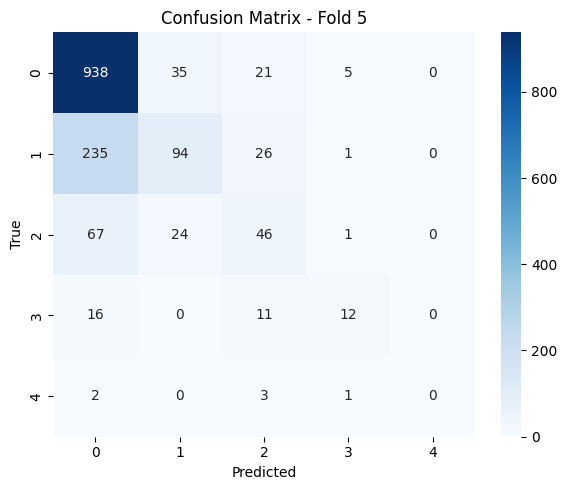

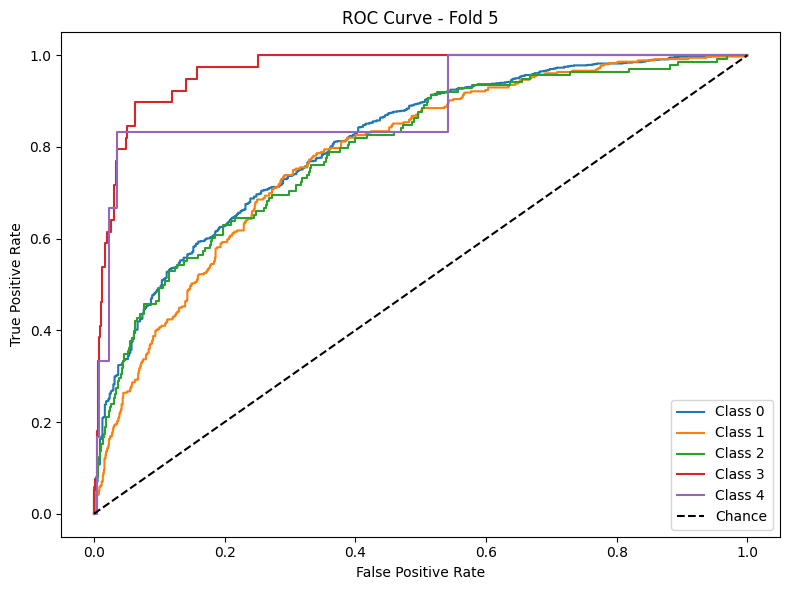


Average Accuracy: 0.7025
Average F1 Macro: 0.3622
Average AUC: 0.8549


In [5]:
# phase_paths = [f"/kaggle/input/smotesvm-enriched-data-with-node2vec/outputs/phase{i}" for i in range(1, 5)]
# results = {}

# for i, phase_path in enumerate(phase_paths, start=1):
#     print(f"\n================================================")
#     print(f"\n============== Training Phase {i} ===============")
#     print(f"\n=================================================")
#     sample = False
#     model, scaler, best_fold, metrics = train_phase(phase_path, sample = sample)
#     # Save best model & scaler
#     if sample: 
#         temp = "sample"
#     else: temp = "no_sample"
#     joblib.dump(model, f"best_model_{temp}_phase{i}.pkl")
#     joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")
#     results[f"phase{i}"] = metrics


phase_paths = [f"/kaggle/input/smotesvm-enriched-data-with-node2vec/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n===================================")
    print(f"\n======= Training Phase {i} ========")
    print(f"\n===================================")
    
    sample = False
    model, scaler, best_fold, metrics = train_phase(phase_path, sample=sample)

    temp = "sample" if sample else "no_sample"

    # ✅ Lưu mô hình LSTM bằng Keras
    model.save(f"best_model_{temp}_phase{i}.h5")

    # ✅ Lưu scaler bằng joblib (vẫn đúng)
    joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")

    results[f"phase{i}"] = metrics


## Predict on Test Data

In [6]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model

def predict_on_test(test_file_path, model_file, scaler_file, school_mapping_file):
    # Load model, scaler, and mapping
    model = load_model(model_file)
    scaler = joblib.load(scaler_file)
    mapping = joblib.load(school_mapping_file)

    # Load and preprocess test data
    df_test = pd.read_csv(test_file_path)
    y_test = df_test['label_encoded'].values
    X_test = df_test.drop(columns=['user_id', 'course_id', 'label_encoded', 'label', 'total_score'], axis=1)

    # Apply school mapping
    if 'school' in X_test.columns:
        X_test['school'] = X_test['school'].map(mapping).fillna(0).astype(int)

    # Scale features
    X_test_scaled = scaler.transform(X_test)

    # Reshape for LSTM (samples, timesteps=1, features)
    X_test_lstm = np.expand_dims(X_test_scaled, axis=1)

    # Predict
    y_proba = model.predict(X_test_lstm)
    y_pred = np.argmax(y_proba, axis=1)

    # Extract classes from y_test (sorted and unique)
    classes = np.unique(np.concatenate((y_test, y_pred)))

    # Classification Report
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred, labels=classes))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # AUC Score
    y_test_bin = label_binarize(y_test, classes=classes)
    auc_score = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')
    print(f"\nTest AUC (macro-average, OVR): {auc_score:.4f}")

    # Plot ROC Curves
    plt.figure(figsize=(8, 6))
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        plt.plot(fpr, tpr, label=f'Class {cls}')

    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.title('ROC Curves for Test Set')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return y_pred


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step 

Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.95      0.90       568
           1       0.22      0.19      0.20        63
           2       0.15      0.05      0.07        43
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00         9

    accuracy                           0.80       698
   macro avg       0.25      0.24      0.24       698
weighted avg       0.73      0.80      0.76       698



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


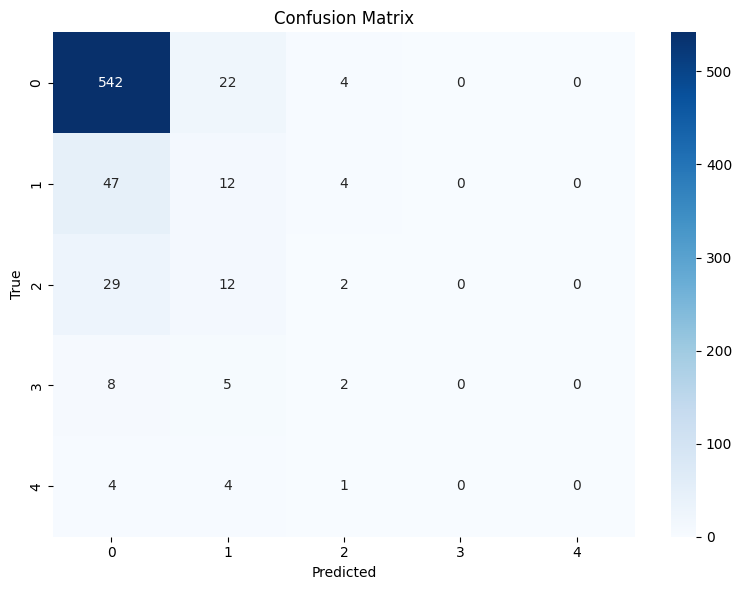


Test AUC (macro-average, OVR): 0.7230


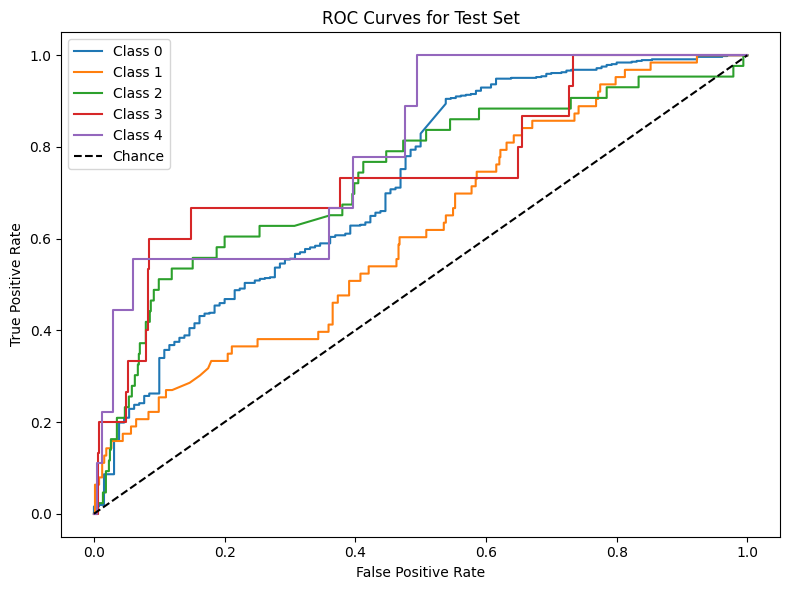

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.96      0.91       544
           1       0.27      0.20      0.23        59
           2       0.20      0.10      0.13        42
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00         9

    accuracy                           0.81       668
   macro avg       0.27      0.25      0.25       668
weighted avg       0.74      0.81      0.77       668



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


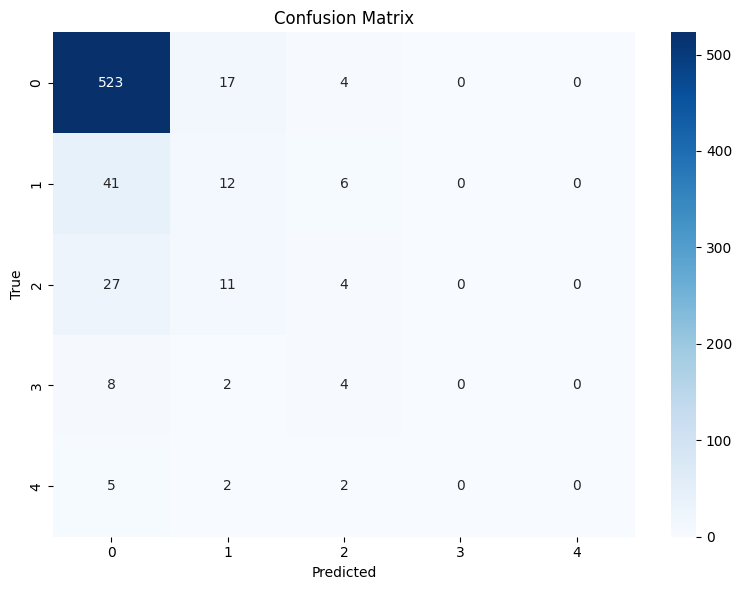


Test AUC (macro-average, OVR): 0.7225


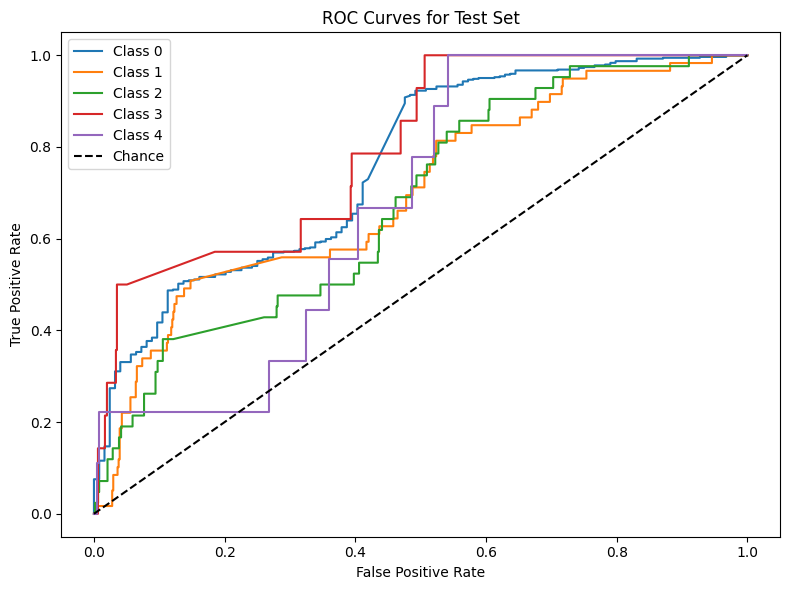

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step 

Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.94      0.92       455
           1       0.35      0.29      0.32        52
           2       0.28      0.28      0.28        29
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.82       554
   macro avg       0.30      0.30      0.30       554
weighted avg       0.78      0.82      0.80       554



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


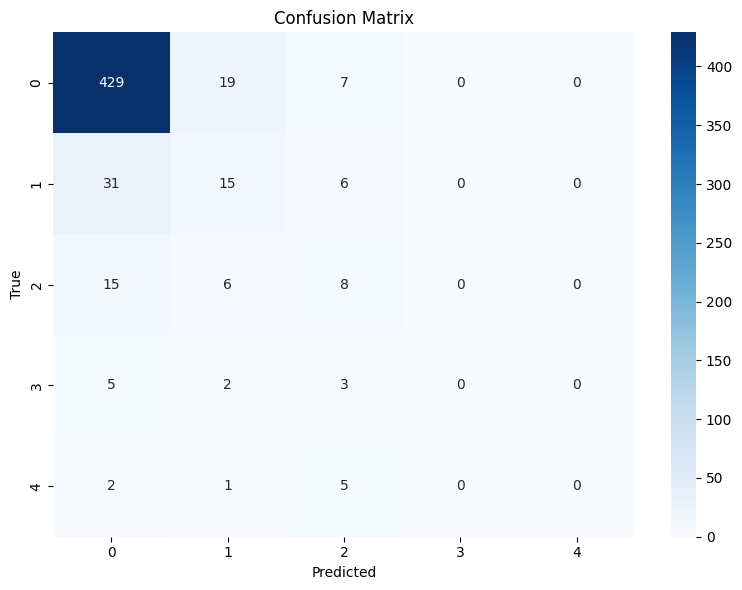


Test AUC (macro-average, OVR): 0.7899


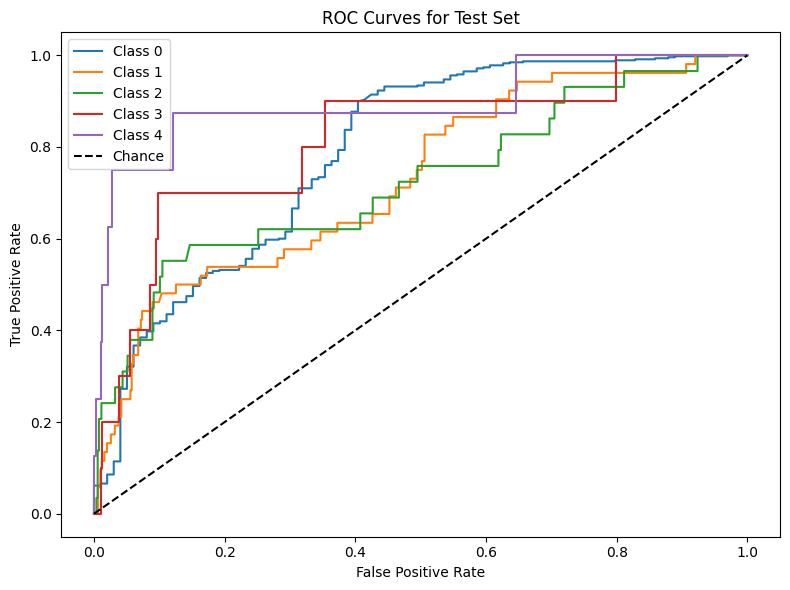

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step 

Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.94      0.92       395
           1       0.26      0.23      0.24        40
           2       0.26      0.25      0.26        24
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.81       477
   macro avg       0.28      0.28      0.28       477
weighted avg       0.77      0.81      0.79       477



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


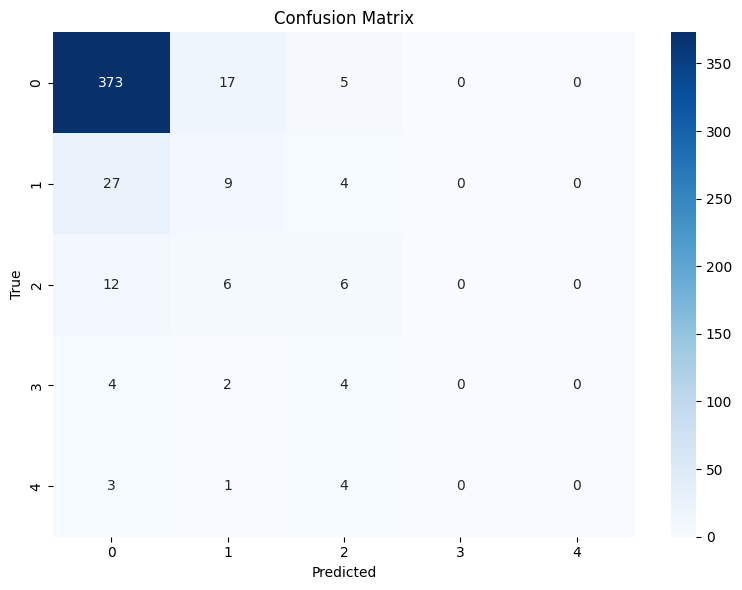


Test AUC (macro-average, OVR): 0.7241


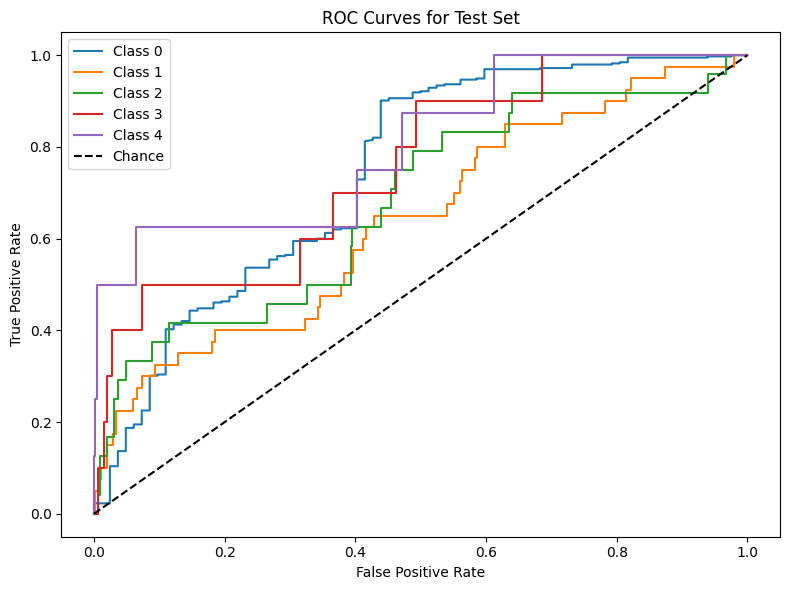

In [7]:
import glob

# for i in range(1, 5):
#     test_dir = f'/kaggle/input/enrich-data-using-node2vector/phase{i}/user_train_phase_{i}_test.csv'
    
#     # Get model and scaler using glob
#     model_path = f'/kaggle/working/best_model_{temp}_phase{i}.pkl'
#     scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
#     # School mapping path
#     school_mapping_file = f'/kaggle/input/smotesvm-enriched-data-with-node2vec/outputs/phase{i}/mappings/school_mapping.pkl'

#     # Predict on test set
#     predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)



for i in range(1, 5):
    test_dir = f'/kaggle/input/enrich-data-using-node2vector/phase{i}/user_train_phase_{i}_test.csv'
    
    # Đường dẫn đúng cho model Keras (.h5)
    model_path = f'/kaggle/working/best_model_{temp}_phase{i}.h5'
    scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
    # Trích xuất mapping trường học
    school_mapping_file = f'/kaggle/input/smotesvm-enriched-data-with-node2vec/outputs/phase{i}/mappings/school_mapping.pkl'

    # Dự đoán trên tập test
    predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)


# Sample


=== Training Phase 1 ===


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
987/987 - 14s - 15ms/step - accuracy: 0.5714 - loss: 0.9769 - val_accuracy: 0.4803 - val_loss: 1.1040
Epoch 2/30
987/987 - 5s - 5ms/step - accuracy: 0.6682 - loss: 0.8199 - val_accuracy: 0.6022 - val_loss: 1.0036
Epoch 3/30
987/987 - 5s - 5ms/step - accuracy: 0.6925 - loss: 0.7785 - val_accuracy: 0.6144 - val_loss: 0.9782
Epoch 4/30
987/987 - 6s - 6ms/step - accuracy: 0.7055 - loss: 0.7566 - val_accuracy: 0.5967 - val_loss: 0.9476
Epoch 5/30
987/987 - 5s - 5ms/step - accuracy: 0.7116 - loss: 0.7385 - val_accuracy: 0.6122 - val_loss: 0.9627
Epoch 6/30
987/987 - 5s - 5ms/step - accuracy: 0.7165 - loss: 0.7284 - val_accuracy: 0.6158 - val_loss: 0.9360
Epoch 7/30
987/987 - 5s - 5ms/step - accuracy: 0.7180 - loss: 0.7164 - val_accuracy: 0.6247 - val_loss: 0.9451
Epoch 8/30
987/987 - 5s - 5ms/step - accuracy: 0.7239 - loss: 0.7048 - val_accuracy: 0.6247 - val_loss: 0.9325
Epoch 9/30
987/987 - 5s - 5ms/step - accuracy: 0.7255 - loss: 0.6990 - val_accuracy: 0.6221 - val_loss: 0.9587

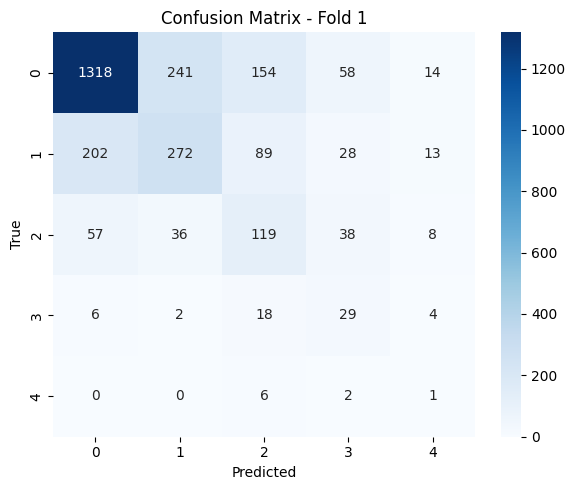

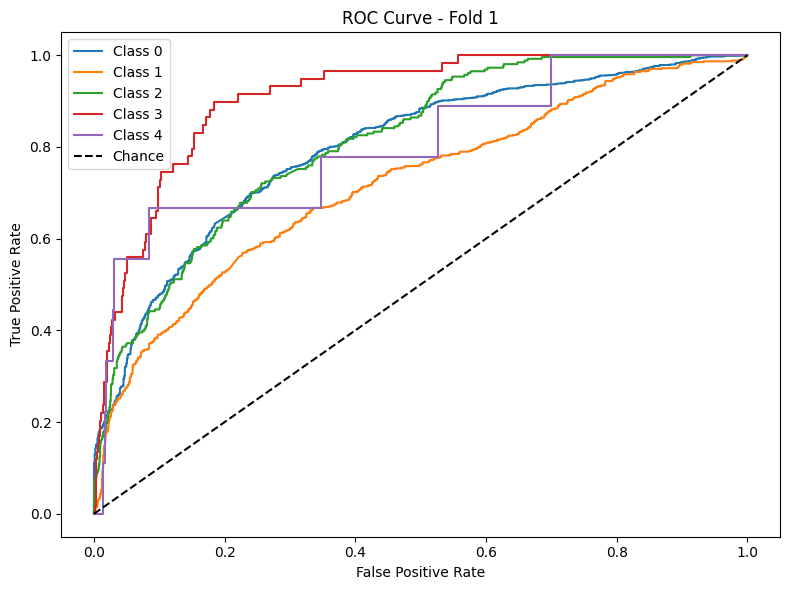

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
987/987 - 19s - 19ms/step - accuracy: 0.5866 - loss: 0.9589 - val_accuracy: 0.5365 - val_loss: 1.0843
Epoch 2/30
987/987 - 6s - 6ms/step - accuracy: 0.6803 - loss: 0.8035 - val_accuracy: 0.6153 - val_loss: 0.9593
Epoch 3/30
987/987 - 6s - 6ms/step - accuracy: 0.7034 - loss: 0.7605 - val_accuracy: 0.5700 - val_loss: 0.9802
Epoch 4/30
987/987 - 6s - 6ms/step - accuracy: 0.7129 - loss: 0.7386 - val_accuracy: 0.5641 - val_loss: 0.9560
Epoch 5/30
987/987 - 6s - 6ms/step - accuracy: 0.7192 - loss: 0.7241 - val_accuracy: 0.6146 - val_loss: 0.9261
Epoch 6/30
987/987 - 6s - 6ms/step - accuracy: 0.7183 - loss: 0.7154 - val_accuracy: 0.6175 - val_loss: 0.9520
Epoch 7/30
987/987 - 6s - 6ms/step - accuracy: 0.7232 - loss: 0.7055 - val_accuracy: 0.5306 - val_loss: 1.0073
Epoch 8/30
987/987 - 6s - 6ms/step - accuracy: 0.7283 - loss: 0.7020 - val_accuracy: 0.6087 - val_loss: 0.9172
Epoch 9/30
987/987 - 6s - 6ms/step - accuracy: 0.7312 - loss: 0.6900 - val_accuracy: 0.6054 - val_loss: 0.9437

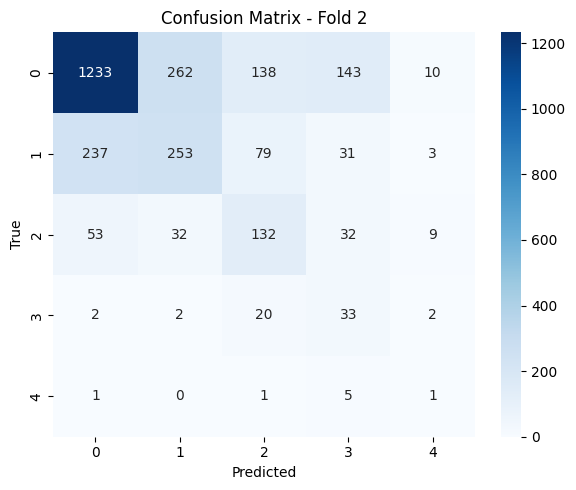

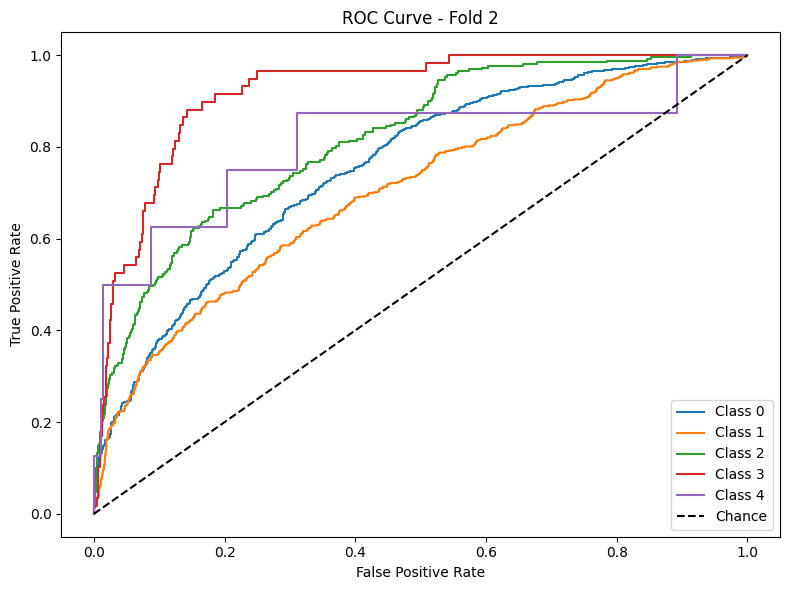

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
987/987 - 16s - 16ms/step - accuracy: 0.5549 - loss: 0.9951 - val_accuracy: 0.4772 - val_loss: 1.0772
Epoch 2/30
987/987 - 6s - 6ms/step - accuracy: 0.6438 - loss: 0.8324 - val_accuracy: 0.5637 - val_loss: 1.0114
Epoch 3/30
987/987 - 6s - 6ms/step - accuracy: 0.6931 - loss: 0.7776 - val_accuracy: 0.6109 - val_loss: 0.9590
Epoch 4/30
987/987 - 6s - 6ms/step - accuracy: 0.7053 - loss: 0.7515 - val_accuracy: 0.6161 - val_loss: 0.9498
Epoch 5/30
987/987 - 6s - 6ms/step - accuracy: 0.7109 - loss: 0.7363 - val_accuracy: 0.5601 - val_loss: 0.9775
Epoch 6/30
987/987 - 6s - 6ms/step - accuracy: 0.7156 - loss: 0.7232 - val_accuracy: 0.5873 - val_loss: 0.9639
Epoch 7/30
987/987 - 6s - 6ms/step - accuracy: 0.7188 - loss: 0.7140 - val_accuracy: 0.6172 - val_loss: 0.9336
Epoch 8/30
987/987 - 6s - 6ms/step - accuracy: 0.7221 - loss: 0.7018 - val_accuracy: 0.5855 - val_loss: 0.9602
Epoch 9/30
987/987 - 6s - 6ms/step - accuracy: 0.7286 - loss: 0.6949 - val_accuracy: 0.5936 - val_loss: 0.9397

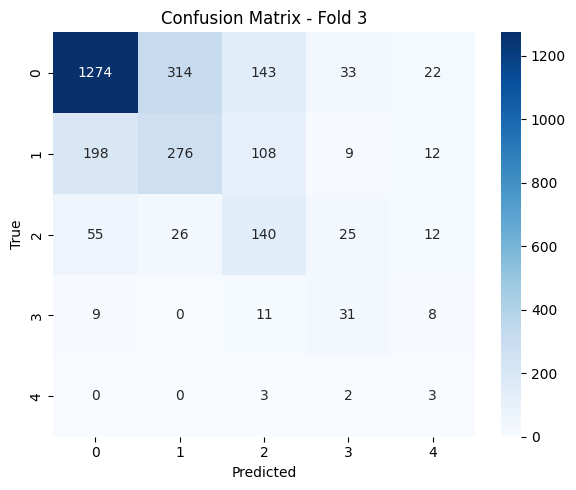

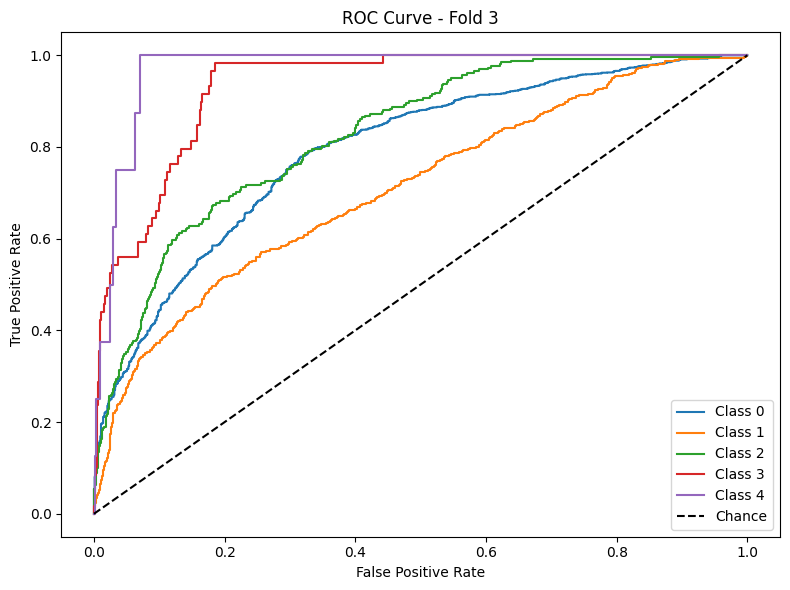

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


987/987 - 14s - 14ms/step - accuracy: 0.5713 - loss: 0.9913 - val_accuracy: 0.6061 - val_loss: 1.0086
Epoch 2/30
987/987 - 5s - 5ms/step - accuracy: 0.6676 - loss: 0.8156 - val_accuracy: 0.5903 - val_loss: 0.9684
Epoch 3/30
987/987 - 5s - 5ms/step - accuracy: 0.6952 - loss: 0.7717 - val_accuracy: 0.6131 - val_loss: 0.9422
Epoch 4/30
987/987 - 5s - 6ms/step - accuracy: 0.7019 - loss: 0.7504 - val_accuracy: 0.6212 - val_loss: 0.9206
Epoch 5/30
987/987 - 5s - 5ms/step - accuracy: 0.7123 - loss: 0.7353 - val_accuracy: 0.5737 - val_loss: 0.9286
Epoch 6/30
987/987 - 5s - 5ms/step - accuracy: 0.7129 - loss: 0.7249 - val_accuracy: 0.6216 - val_loss: 0.9319
Epoch 7/30
987/987 - 5s - 5ms/step - accuracy: 0.7150 - loss: 0.7156 - val_accuracy: 0.6253 - val_loss: 0.9148
Epoch 8/30
987/987 - 5s - 5ms/step - accuracy: 0.7223 - loss: 0.7025 - val_accuracy: 0.6072 - val_loss: 0.9418
Epoch 9/30
987/987 - 5s - 5ms/step - accuracy: 0.7232 - loss: 0.6987 - val_accuracy: 0.6271 - val_loss: 0.8842
Epoch 10/3

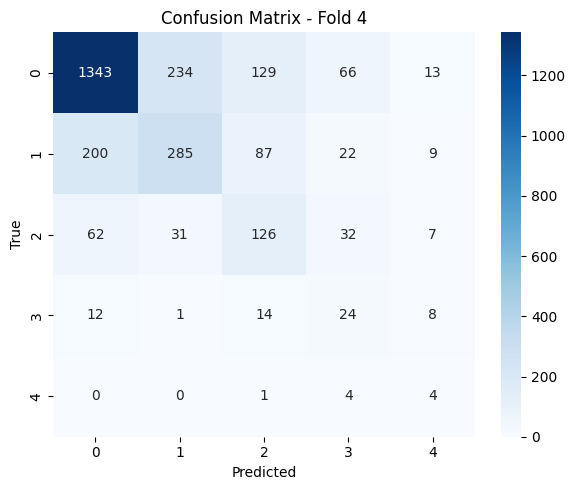

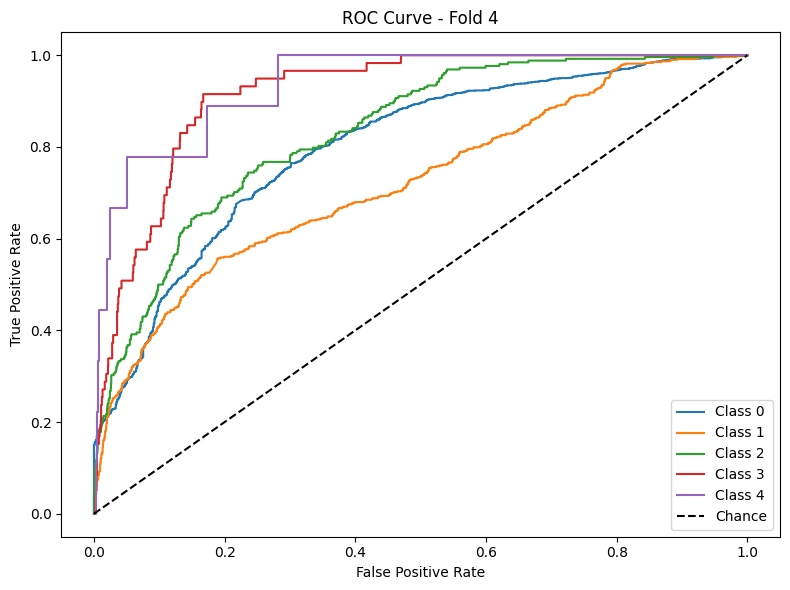

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


987/987 - 17s - 17ms/step - accuracy: 0.6002 - loss: 0.9405 - val_accuracy: 0.6050 - val_loss: 0.9856
Epoch 2/30
987/987 - 5s - 5ms/step - accuracy: 0.6973 - loss: 0.7649 - val_accuracy: 0.5859 - val_loss: 0.9609
Epoch 3/30
987/987 - 5s - 5ms/step - accuracy: 0.7080 - loss: 0.7321 - val_accuracy: 0.6275 - val_loss: 0.9216
Epoch 4/30
987/987 - 6s - 6ms/step - accuracy: 0.7172 - loss: 0.7112 - val_accuracy: 0.6083 - val_loss: 0.9431
Epoch 5/30
987/987 - 5s - 5ms/step - accuracy: 0.7221 - loss: 0.7003 - val_accuracy: 0.6371 - val_loss: 0.9181
Epoch 6/30
987/987 - 5s - 6ms/step - accuracy: 0.7252 - loss: 0.6904 - val_accuracy: 0.6382 - val_loss: 0.9152
Epoch 7/30
987/987 - 5s - 5ms/step - accuracy: 0.7285 - loss: 0.6806 - val_accuracy: 0.6459 - val_loss: 0.9144
Epoch 8/30
987/987 - 5s - 5ms/step - accuracy: 0.7340 - loss: 0.6721 - val_accuracy: 0.6466 - val_loss: 0.8992
Epoch 9/30
987/987 - 5s - 5ms/step - accuracy: 0.7367 - loss: 0.6677 - val_accuracy: 0.6562 - val_loss: 0.8878
Epoch 10/3

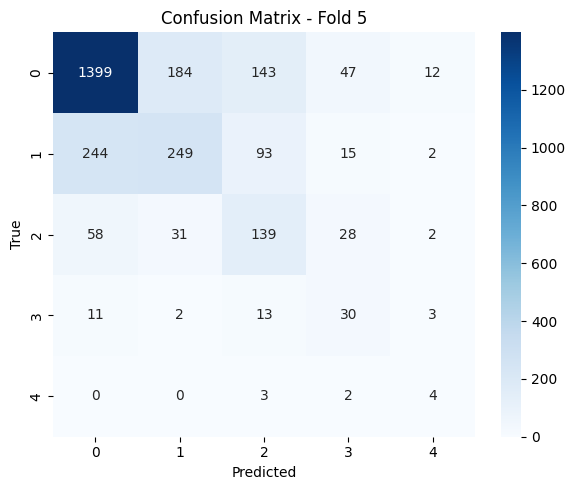

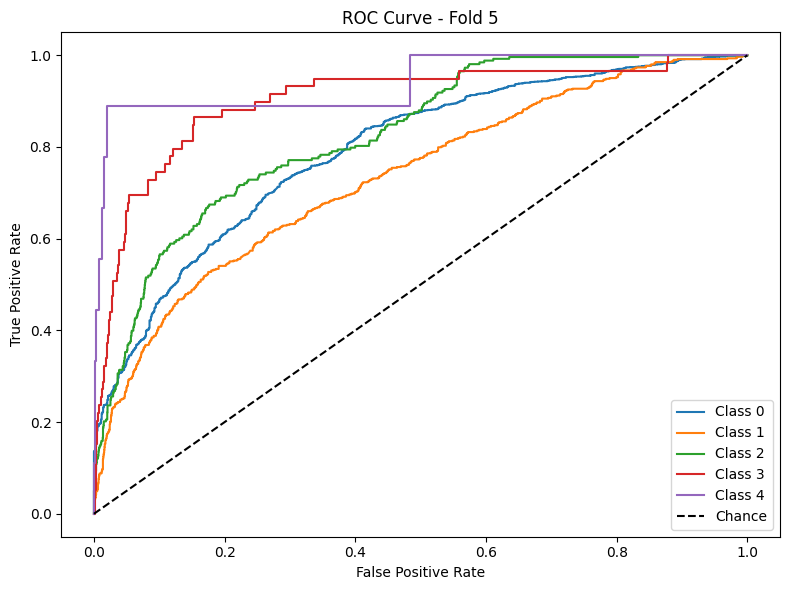


Average Accuracy: 0.6424
Average F1 Macro: 0.4121
Average AUC: 0.8272

=== Training Phase 2 ===
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


824/824 - 15s - 18ms/step - accuracy: 0.5776 - loss: 0.9735 - val_accuracy: 0.5040 - val_loss: 1.0630
Epoch 2/30
824/824 - 5s - 6ms/step - accuracy: 0.6720 - loss: 0.8084 - val_accuracy: 0.5982 - val_loss: 1.0422
Epoch 3/30
824/824 - 5s - 6ms/step - accuracy: 0.6970 - loss: 0.7669 - val_accuracy: 0.6385 - val_loss: 1.0009
Epoch 4/30
824/824 - 5s - 6ms/step - accuracy: 0.7057 - loss: 0.7413 - val_accuracy: 0.6093 - val_loss: 0.9863
Epoch 5/30
824/824 - 5s - 6ms/step - accuracy: 0.7115 - loss: 0.7211 - val_accuracy: 0.6473 - val_loss: 0.9580
Epoch 6/30
824/824 - 5s - 6ms/step - accuracy: 0.7146 - loss: 0.7108 - val_accuracy: 0.6615 - val_loss: 0.9087
Epoch 7/30
824/824 - 5s - 6ms/step - accuracy: 0.7192 - loss: 0.7016 - val_accuracy: 0.6296 - val_loss: 0.9342
Epoch 8/30
824/824 - 5s - 6ms/step - accuracy: 0.7223 - loss: 0.6923 - val_accuracy: 0.6239 - val_loss: 0.9386
Epoch 9/30
824/824 - 5s - 6ms/step - accuracy: 0.7246 - loss: 0.6844 - val_accuracy: 0.6128 - val_loss: 0.9538
Epoch 10/3

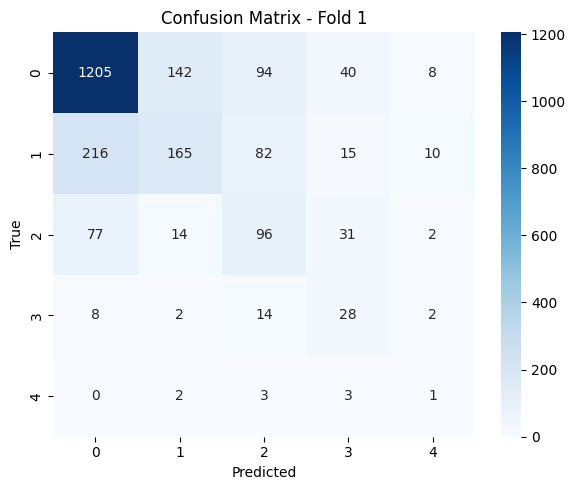

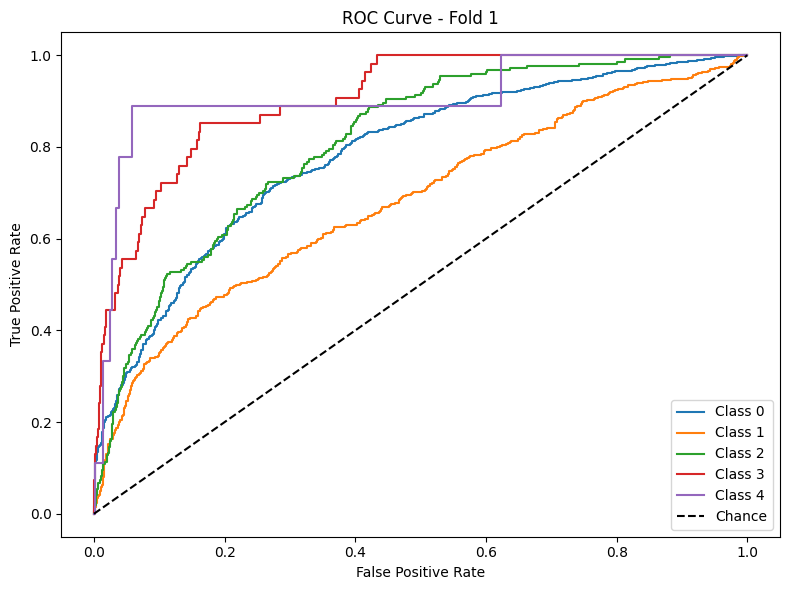

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
824/824 - 18s - 22ms/step - accuracy: 0.5760 - loss: 0.9563 - val_accuracy: 0.4721 - val_loss: 1.1177
Epoch 2/30
824/824 - 5s - 6ms/step - accuracy: 0.6730 - loss: 0.7873 - val_accuracy: 0.5721 - val_loss: 1.0759
Epoch 3/30
824/824 - 5s - 6ms/step - accuracy: 0.7038 - loss: 0.7411 - val_accuracy: 0.6350 - val_loss: 0.9582
Epoch 4/30
824/824 - 5s - 6ms/step - accuracy: 0.7108 - loss: 0.7185 - val_accuracy: 0.6332 - val_loss: 0.9418
Epoch 5/30
824/824 - 5s - 6ms/step - accuracy: 0.7195 - loss: 0.7039 - val_accuracy: 0.5982 - val_loss: 0.9677
Epoch 6/30
824/824 - 5s - 6ms/step - accuracy: 0.7277 - loss: 0.6892 - val_accuracy: 0.6283 - val_loss: 0.9534
Epoch 7/30
824/824 - 5s - 6ms/step - accuracy: 0.7280 - loss: 0.6839 - val_accuracy: 0.6456 - val_loss: 0.9236
Epoch 8/30
824/824 - 5s - 6ms/step - accuracy: 0.7317 - loss: 0.6727 - val_accuracy: 0.6296 - val_loss: 0.9257
Epoch 9/30
824/824 - 5s - 6ms/step - accuracy: 0.7339 - loss: 0.6670 - val_accuracy: 0.6013 - val_loss: 0.9623

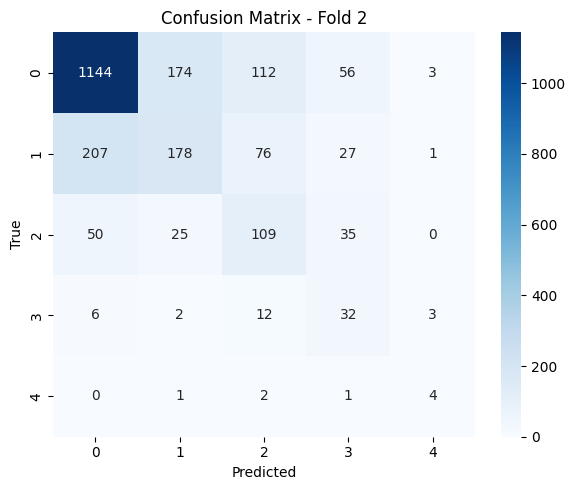

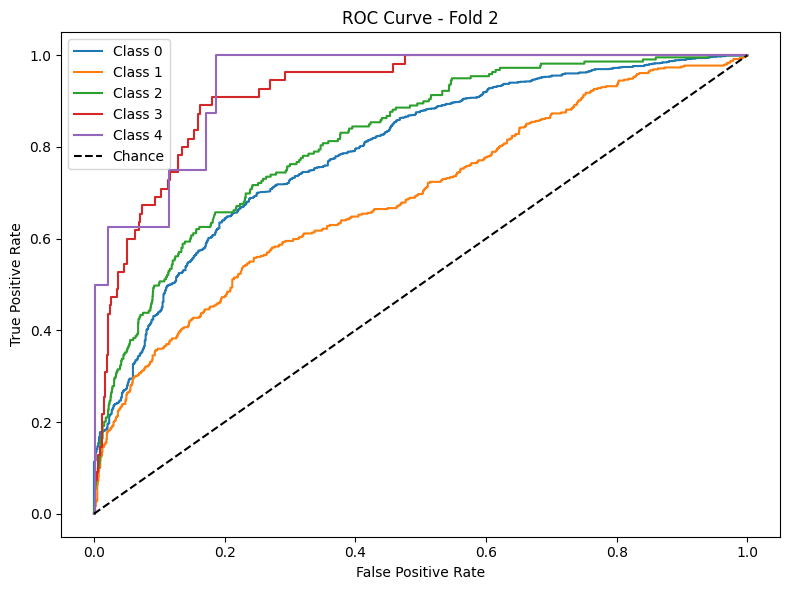

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
824/824 - 15s - 18ms/step - accuracy: 0.5821 - loss: 0.9662 - val_accuracy: 0.5392 - val_loss: 1.0999
Epoch 2/30
824/824 - 5s - 6ms/step - accuracy: 0.6861 - loss: 0.7901 - val_accuracy: 0.6184 - val_loss: 1.0012
Epoch 3/30
824/824 - 5s - 6ms/step - accuracy: 0.7042 - loss: 0.7512 - val_accuracy: 0.6122 - val_loss: 0.9834
Epoch 4/30
824/824 - 5s - 6ms/step - accuracy: 0.7125 - loss: 0.7291 - val_accuracy: 0.6166 - val_loss: 0.9938
Epoch 5/30
824/824 - 5s - 6ms/step - accuracy: 0.7215 - loss: 0.7131 - val_accuracy: 0.6003 - val_loss: 0.9984
Epoch 6/30
824/824 - 5s - 6ms/step - accuracy: 0.7260 - loss: 0.6968 - val_accuracy: 0.6237 - val_loss: 0.9808
Epoch 7/30
824/824 - 5s - 6ms/step - accuracy: 0.7294 - loss: 0.6872 - val_accuracy: 0.6025 - val_loss: 1.0017
Epoch 8/30
824/824 - 5s - 6ms/step - accuracy: 0.7322 - loss: 0.6775 - val_accuracy: 0.6184 - val_loss: 0.9653
Epoch 9/30
824/824 - 5s - 6ms/step - accuracy: 0.7316 - loss: 0.6743 - val_accuracy: 0.5879 - val_loss: 0.9538

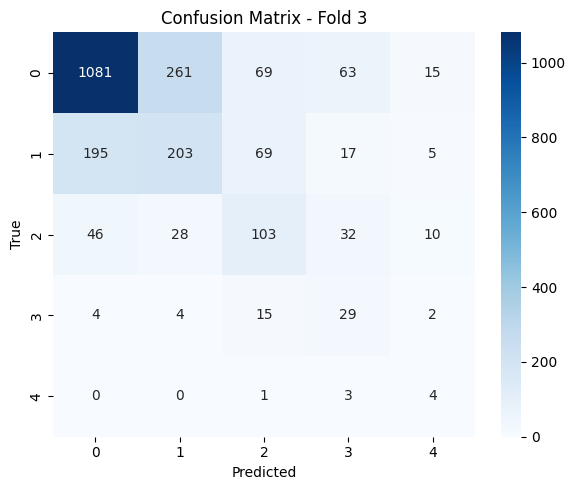

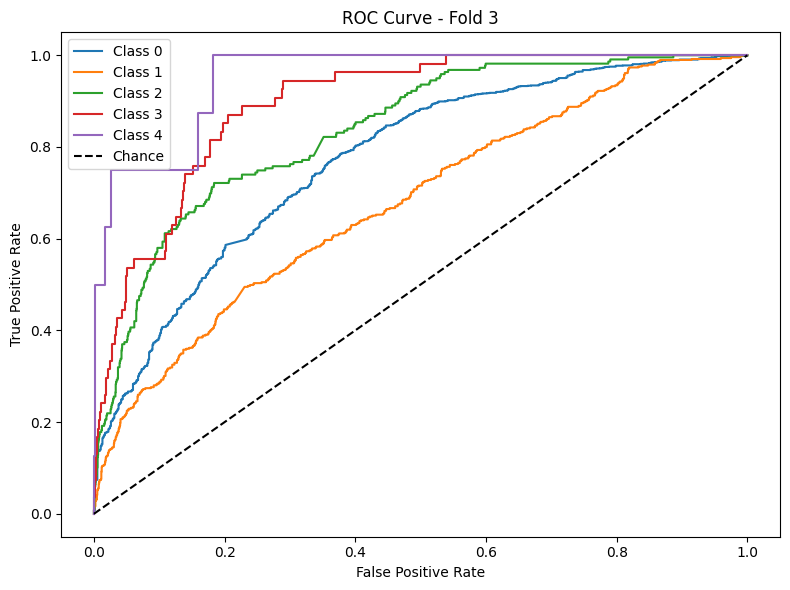

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


824/824 - 15s - 18ms/step - accuracy: 0.5575 - loss: 1.0097 - val_accuracy: 0.5312 - val_loss: 1.0839
Epoch 2/30
824/824 - 5s - 6ms/step - accuracy: 0.6612 - loss: 0.8359 - val_accuracy: 0.6228 - val_loss: 0.9689
Epoch 3/30
824/824 - 5s - 6ms/step - accuracy: 0.6897 - loss: 0.7909 - val_accuracy: 0.6339 - val_loss: 0.9342
Epoch 4/30
824/824 - 5s - 6ms/step - accuracy: 0.6970 - loss: 0.7721 - val_accuracy: 0.6193 - val_loss: 0.9381
Epoch 5/30
824/824 - 5s - 6ms/step - accuracy: 0.7031 - loss: 0.7609 - val_accuracy: 0.6255 - val_loss: 0.9280
Epoch 6/30
824/824 - 5s - 6ms/step - accuracy: 0.7092 - loss: 0.7467 - val_accuracy: 0.6476 - val_loss: 0.8922
Epoch 7/30
824/824 - 5s - 6ms/step - accuracy: 0.7143 - loss: 0.7349 - val_accuracy: 0.6299 - val_loss: 0.9098
Epoch 8/30
824/824 - 5s - 6ms/step - accuracy: 0.7176 - loss: 0.7247 - val_accuracy: 0.6082 - val_loss: 0.9482
Epoch 9/30
824/824 - 5s - 6ms/step - accuracy: 0.7208 - loss: 0.7181 - val_accuracy: 0.6485 - val_loss: 0.8951
Epoch 10/3

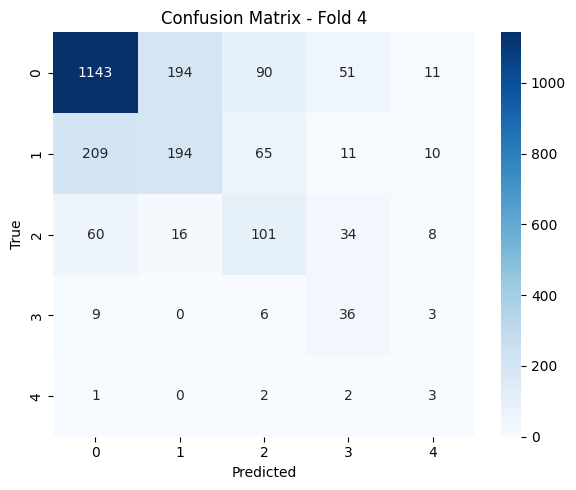

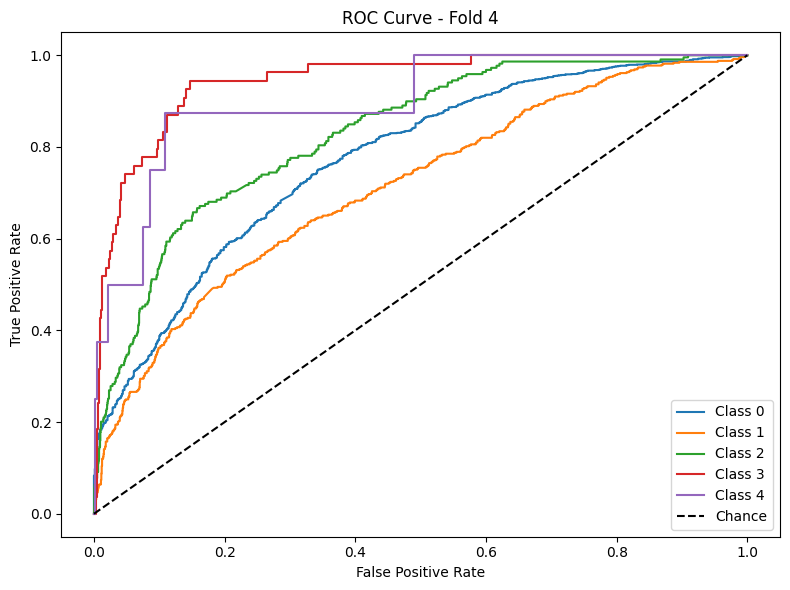

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


824/824 - 18s - 22ms/step - accuracy: 0.5897 - loss: 0.9543 - val_accuracy: 0.4861 - val_loss: 1.1054
Epoch 2/30
824/824 - 5s - 6ms/step - accuracy: 0.6891 - loss: 0.7765 - val_accuracy: 0.6104 - val_loss: 1.0291
Epoch 3/30
824/824 - 5s - 6ms/step - accuracy: 0.7120 - loss: 0.7348 - val_accuracy: 0.5972 - val_loss: 0.9768
Epoch 4/30
824/824 - 5s - 6ms/step - accuracy: 0.7253 - loss: 0.7107 - val_accuracy: 0.5768 - val_loss: 1.0174
Epoch 5/30
824/824 - 5s - 6ms/step - accuracy: 0.7294 - loss: 0.6993 - val_accuracy: 0.6025 - val_loss: 0.9965
Epoch 6/30
824/824 - 5s - 6ms/step - accuracy: 0.7324 - loss: 0.6894 - val_accuracy: 0.5972 - val_loss: 0.9938
Epoch 7/30
824/824 - 5s - 6ms/step - accuracy: 0.7372 - loss: 0.6799 - val_accuracy: 0.6344 - val_loss: 0.9251
Epoch 8/30
824/824 - 5s - 6ms/step - accuracy: 0.7367 - loss: 0.6759 - val_accuracy: 0.5941 - val_loss: 0.9944
Epoch 9/30
824/824 - 5s - 6ms/step - accuracy: 0.7373 - loss: 0.6699 - val_accuracy: 0.5989 - val_loss: 0.9746
Epoch 10/3

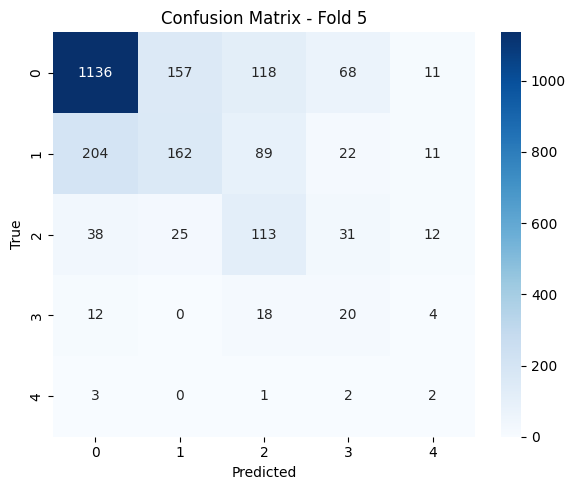

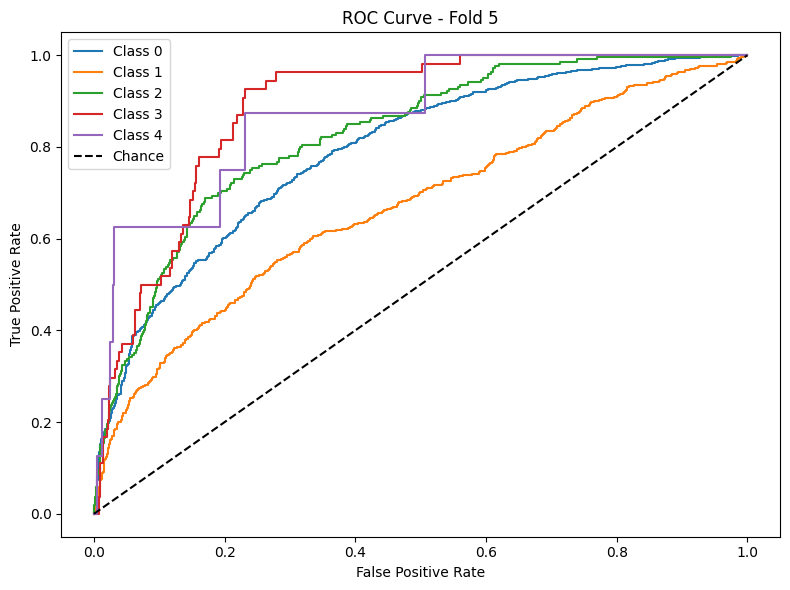


Average Accuracy: 0.6455
Average F1 Macro: 0.4175
Average AUC: 0.8232

=== Training Phase 3 ===


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
752/752 - 15s - 20ms/step - accuracy: 0.5928 - loss: 0.9573 - val_accuracy: 0.5468 - val_loss: 1.0673
Epoch 2/30
752/752 - 5s - 6ms/step - accuracy: 0.7027 - loss: 0.7558 - val_accuracy: 0.6239 - val_loss: 0.9648
Epoch 3/30
752/752 - 5s - 6ms/step - accuracy: 0.7208 - loss: 0.7182 - val_accuracy: 0.6567 - val_loss: 0.9399
Epoch 4/30
752/752 - 5s - 6ms/step - accuracy: 0.7327 - loss: 0.6941 - val_accuracy: 0.6567 - val_loss: 0.9436
Epoch 5/30
752/752 - 5s - 6ms/step - accuracy: 0.7406 - loss: 0.6778 - val_accuracy: 0.6172 - val_loss: 0.9479
Epoch 6/30
752/752 - 5s - 6ms/step - accuracy: 0.7430 - loss: 0.6678 - val_accuracy: 0.6225 - val_loss: 0.9573
Epoch 7/30
752/752 - 5s - 6ms/step - accuracy: 0.7468 - loss: 0.6583 - val_accuracy: 0.6596 - val_loss: 0.9107
Epoch 8/30
752/752 - 5s - 6ms/step - accuracy: 0.7497 - loss: 0.6497 - val_accuracy: 0.6490 - val_loss: 0.9010
Epoch 9/30
752/752 - 5s - 6ms/step - accuracy: 0.7529 - loss: 0.6448 - val_accuracy: 0.6446 - val_loss: 0.8970

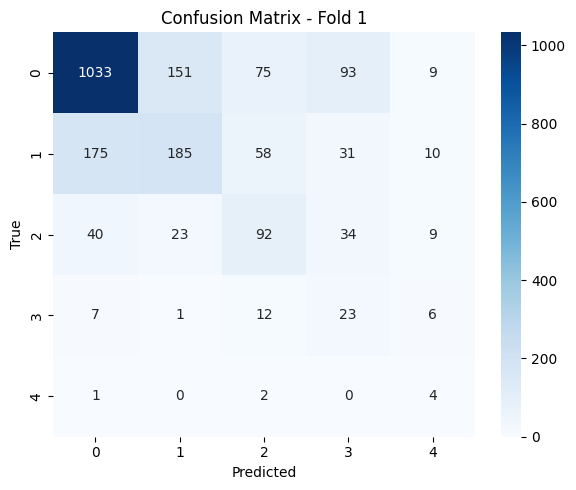

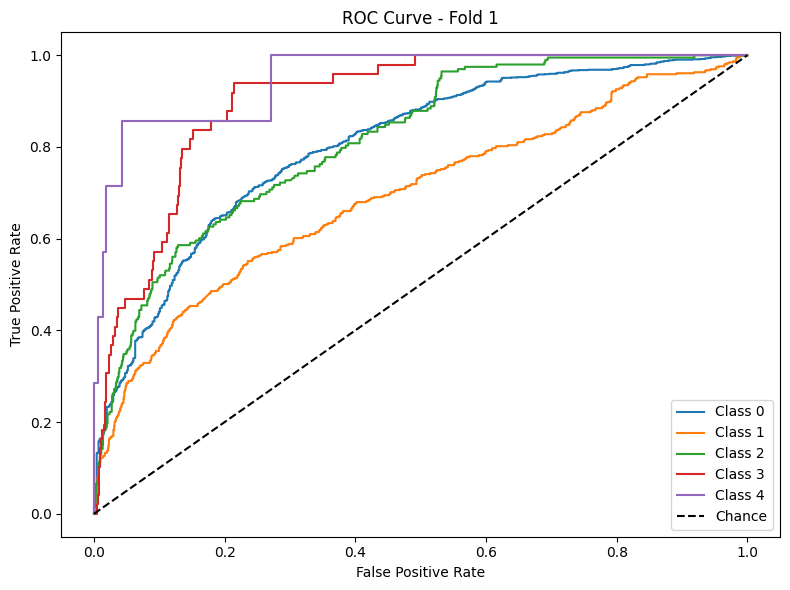

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
752/752 - 15s - 20ms/step - accuracy: 0.5749 - loss: 0.9765 - val_accuracy: 0.5458 - val_loss: 1.0642
Epoch 2/30
752/752 - 5s - 6ms/step - accuracy: 0.6719 - loss: 0.7991 - val_accuracy: 0.6114 - val_loss: 0.9732
Epoch 3/30
752/752 - 5s - 6ms/step - accuracy: 0.7059 - loss: 0.7584 - val_accuracy: 0.6451 - val_loss: 0.9340
Epoch 4/30
752/752 - 5s - 6ms/step - accuracy: 0.7246 - loss: 0.7238 - val_accuracy: 0.6186 - val_loss: 0.9635
Epoch 5/30
752/752 - 5s - 6ms/step - accuracy: 0.7267 - loss: 0.7064 - val_accuracy: 0.6466 - val_loss: 0.9387
Epoch 6/30
752/752 - 5s - 6ms/step - accuracy: 0.7316 - loss: 0.6965 - val_accuracy: 0.5993 - val_loss: 0.9278
Epoch 7/30
752/752 - 5s - 6ms/step - accuracy: 0.7380 - loss: 0.6823 - val_accuracy: 0.6114 - val_loss: 0.9706
Epoch 8/30
752/752 - 5s - 6ms/step - accuracy: 0.7400 - loss: 0.6743 - val_accuracy: 0.6369 - val_loss: 0.9282
Epoch 9/30
752/752 - 5s - 6ms/step - accuracy: 0.7438 - loss: 0.6650 - val_accuracy: 0.6336 - val_loss: 0.9449

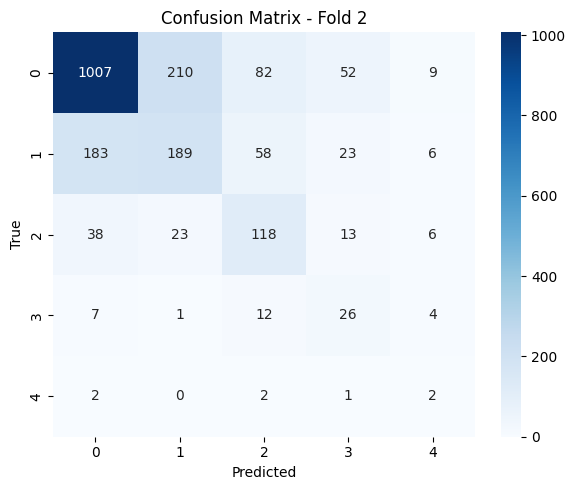

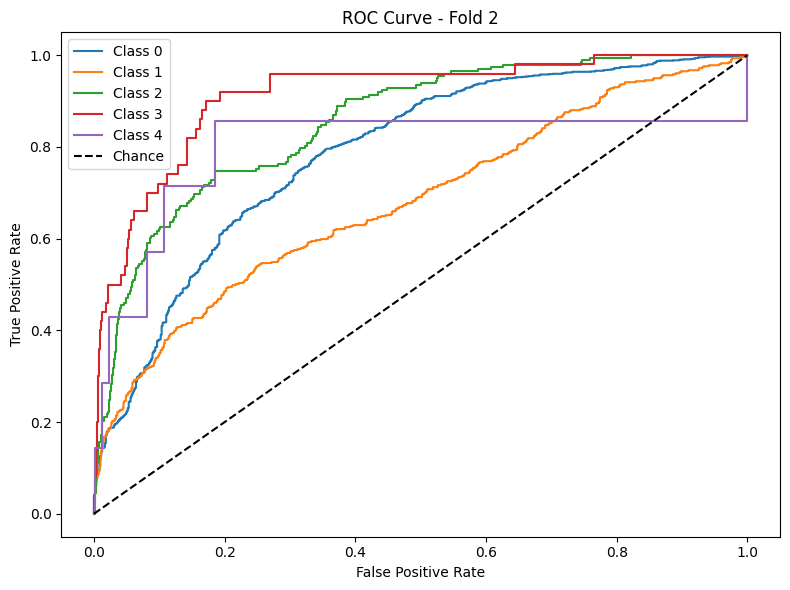

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
752/752 - 15s - 20ms/step - accuracy: 0.5713 - loss: 0.9758 - val_accuracy: 0.5198 - val_loss: 1.1281
Epoch 2/30
752/752 - 5s - 6ms/step - accuracy: 0.6749 - loss: 0.7996 - val_accuracy: 0.5458 - val_loss: 1.1024
Epoch 3/30
752/752 - 5s - 6ms/step - accuracy: 0.7074 - loss: 0.7541 - val_accuracy: 0.5882 - val_loss: 0.9986
Epoch 4/30
752/752 - 5s - 6ms/step - accuracy: 0.7172 - loss: 0.7271 - val_accuracy: 0.6249 - val_loss: 0.9517
Epoch 5/30
752/752 - 5s - 6ms/step - accuracy: 0.7270 - loss: 0.7061 - val_accuracy: 0.5400 - val_loss: 1.0566
Epoch 6/30
752/752 - 5s - 6ms/step - accuracy: 0.7346 - loss: 0.6900 - val_accuracy: 0.5926 - val_loss: 0.9933
Epoch 7/30
752/752 - 5s - 6ms/step - accuracy: 0.7368 - loss: 0.6809 - val_accuracy: 0.6283 - val_loss: 0.9501
Epoch 8/30
752/752 - 5s - 6ms/step - accuracy: 0.7397 - loss: 0.6766 - val_accuracy: 0.6196 - val_loss: 0.9725
Epoch 9/30
752/752 - 5s - 6ms/step - accuracy: 0.7435 - loss: 0.6670 - val_accuracy: 0.6172 - val_loss: 0.9386

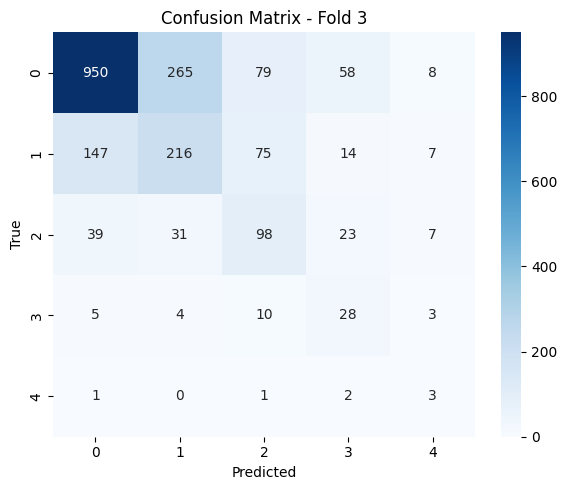

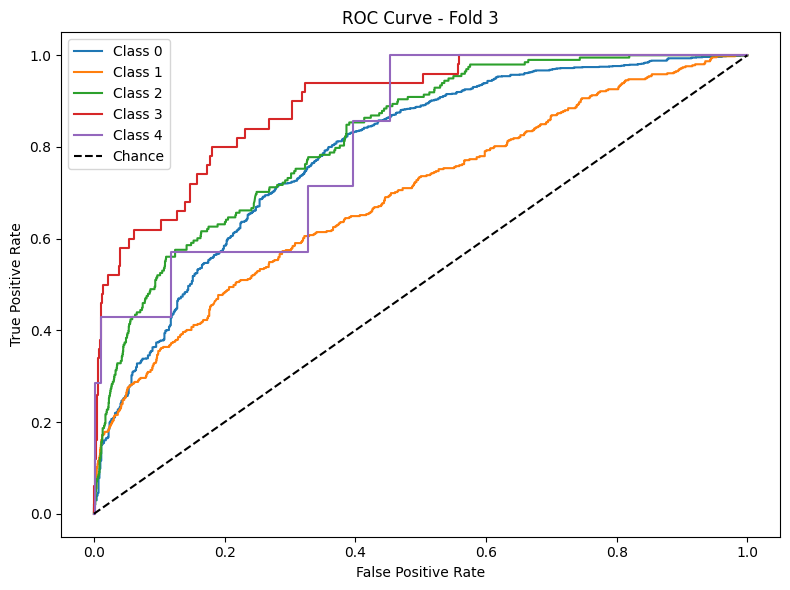

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
752/752 - 15s - 20ms/step - accuracy: 0.5968 - loss: 0.9579 - val_accuracy: 0.4759 - val_loss: 1.0631
Epoch 2/30
752/752 - 5s - 6ms/step - accuracy: 0.6874 - loss: 0.7859 - val_accuracy: 0.6138 - val_loss: 0.9988
Epoch 3/30
752/752 - 5s - 6ms/step - accuracy: 0.7103 - loss: 0.7446 - val_accuracy: 0.6326 - val_loss: 0.9580
Epoch 4/30
752/752 - 5s - 7ms/step - accuracy: 0.7181 - loss: 0.7173 - val_accuracy: 0.5984 - val_loss: 0.9673
Epoch 5/30
752/752 - 5s - 6ms/step - accuracy: 0.7259 - loss: 0.7002 - val_accuracy: 0.5824 - val_loss: 0.9549
Epoch 6/30
752/752 - 5s - 6ms/step - accuracy: 0.7344 - loss: 0.6844 - val_accuracy: 0.5955 - val_loss: 0.9642
Epoch 7/30
752/752 - 5s - 6ms/step - accuracy: 0.7412 - loss: 0.6699 - val_accuracy: 0.6201 - val_loss: 0.9458
Epoch 8/30
752/752 - 5s - 6ms/step - accuracy: 0.7423 - loss: 0.6596 - val_accuracy: 0.5646 - val_loss: 1.0053
Epoch 9/30
752/752 - 5s - 6ms/step - accuracy: 0.7445 - loss: 0.6545 - val_accuracy: 0.6008 - val_loss: 0.9403

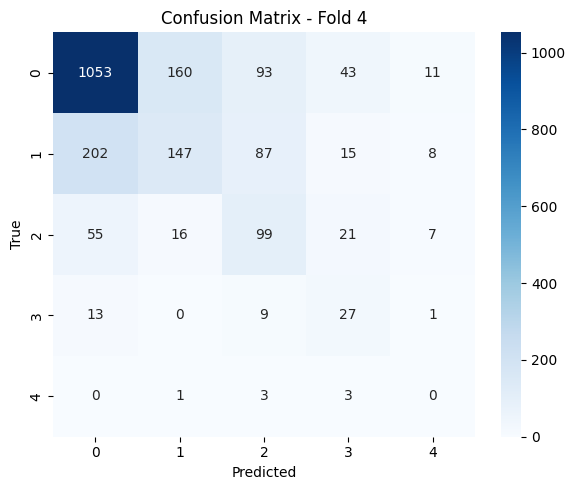

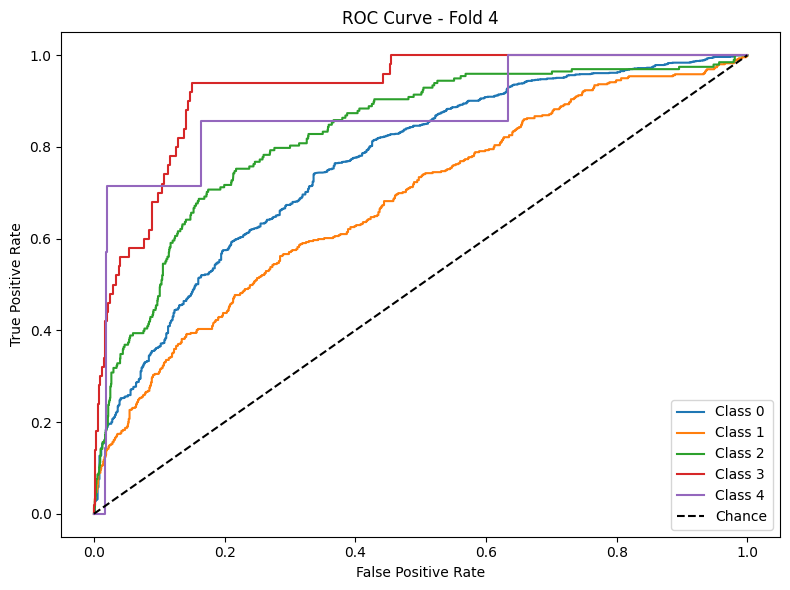

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


752/752 - 15s - 20ms/step - accuracy: 0.5764 - loss: 0.9669 - val_accuracy: 0.2499 - val_loss: 1.1951
Epoch 2/30
752/752 - 5s - 6ms/step - accuracy: 0.6761 - loss: 0.7937 - val_accuracy: 0.5938 - val_loss: 1.0817
Epoch 3/30
752/752 - 5s - 6ms/step - accuracy: 0.7142 - loss: 0.7419 - val_accuracy: 0.6044 - val_loss: 1.0206
Epoch 4/30
752/752 - 5s - 6ms/step - accuracy: 0.7247 - loss: 0.7155 - val_accuracy: 0.6160 - val_loss: 0.9903
Epoch 5/30
752/752 - 5s - 6ms/step - accuracy: 0.7303 - loss: 0.7009 - val_accuracy: 0.6358 - val_loss: 0.9704
Epoch 6/30
752/752 - 5s - 6ms/step - accuracy: 0.7334 - loss: 0.6885 - val_accuracy: 0.5996 - val_loss: 1.0039
Epoch 7/30
752/752 - 5s - 6ms/step - accuracy: 0.7397 - loss: 0.6789 - val_accuracy: 0.6329 - val_loss: 0.9428
Epoch 8/30
752/752 - 5s - 6ms/step - accuracy: 0.7422 - loss: 0.6693 - val_accuracy: 0.6194 - val_loss: 1.0041
Epoch 9/30
752/752 - 5s - 6ms/step - accuracy: 0.7437 - loss: 0.6632 - val_accuracy: 0.5856 - val_loss: 0.9865
Epoch 10/3

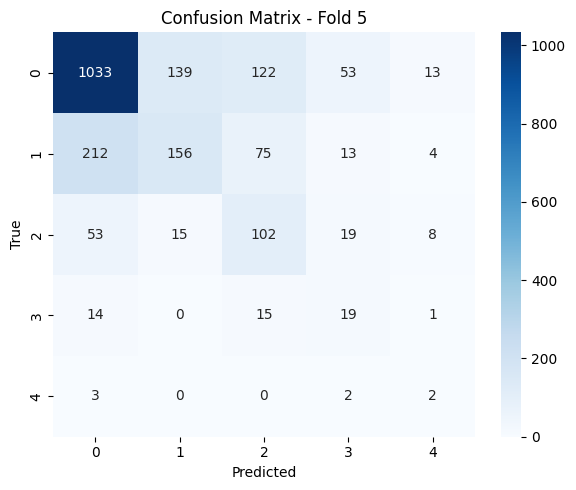

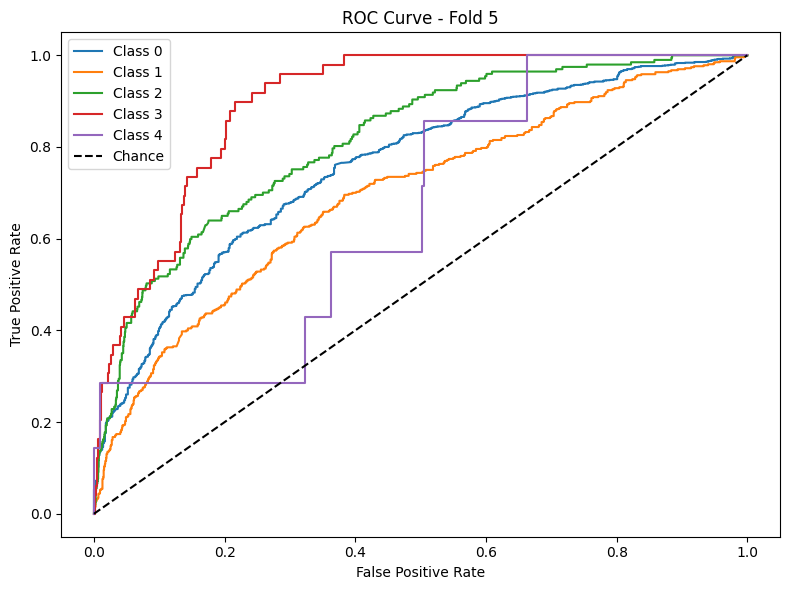


Average Accuracy: 0.6377
Average F1 Macro: 0.4056
Average AUC: 0.8039

=== Training Phase 4 ===


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
553/553 - 14s - 25ms/step - accuracy: 0.5695 - loss: 1.0148 - val_accuracy: 0.5374 - val_loss: 1.0524
Epoch 2/30
553/553 - 3s - 6ms/step - accuracy: 0.7119 - loss: 0.7558 - val_accuracy: 0.5705 - val_loss: 1.0289
Epoch 3/30
553/553 - 3s - 6ms/step - accuracy: 0.7309 - loss: 0.6998 - val_accuracy: 0.6030 - val_loss: 1.0038
Epoch 4/30
553/553 - 4s - 6ms/step - accuracy: 0.7404 - loss: 0.6739 - val_accuracy: 0.5932 - val_loss: 0.9877
Epoch 5/30
553/553 - 4s - 6ms/step - accuracy: 0.7479 - loss: 0.6589 - val_accuracy: 0.5919 - val_loss: 1.0085
Epoch 6/30
553/553 - 3s - 6ms/step - accuracy: 0.7544 - loss: 0.6371 - val_accuracy: 0.6153 - val_loss: 0.9559
Epoch 7/30
553/553 - 4s - 6ms/step - accuracy: 0.7561 - loss: 0.6308 - val_accuracy: 0.6121 - val_loss: 0.9516
Epoch 8/30
553/553 - 4s - 6ms/step - accuracy: 0.7615 - loss: 0.6205 - val_accuracy: 0.6095 - val_loss: 0.9390
Epoch 9/30
553/553 - 3s - 6ms/step - accuracy: 0.7640 - loss: 0.6109 - val_accuracy: 0.5893 - val_loss: 0.9762

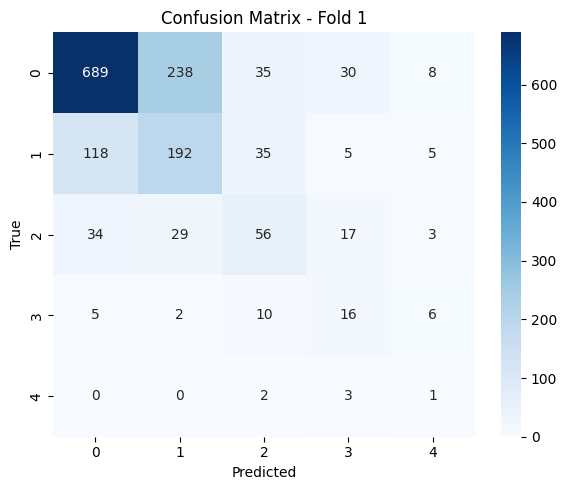

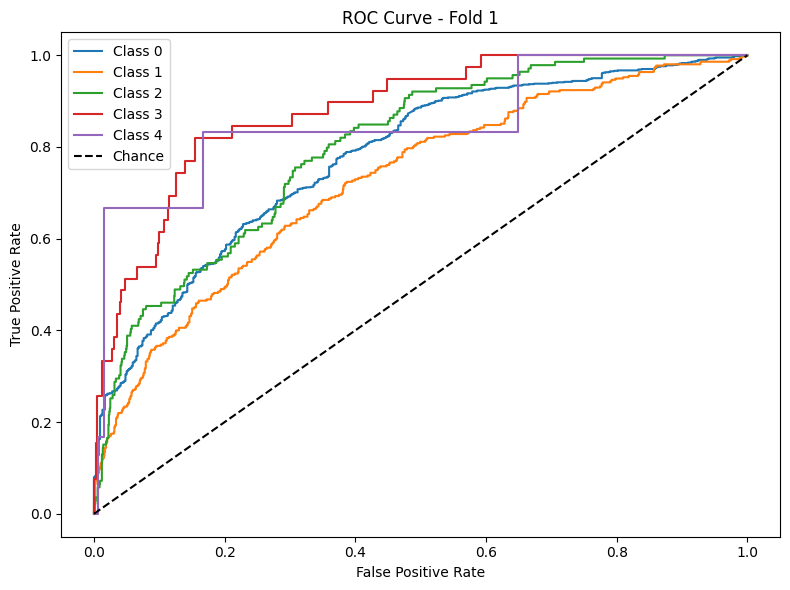

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
553/553 - 14s - 25ms/step - accuracy: 0.5520 - loss: 1.0146 - val_accuracy: 0.5575 - val_loss: 1.0720
Epoch 2/30
553/553 - 3s - 6ms/step - accuracy: 0.7143 - loss: 0.7434 - val_accuracy: 0.5380 - val_loss: 1.0322
Epoch 3/30
553/553 - 3s - 6ms/step - accuracy: 0.7383 - loss: 0.6973 - val_accuracy: 0.6238 - val_loss: 0.9213
Epoch 4/30
553/553 - 3s - 6ms/step - accuracy: 0.7514 - loss: 0.6632 - val_accuracy: 0.6251 - val_loss: 0.9137
Epoch 5/30
553/553 - 3s - 6ms/step - accuracy: 0.7526 - loss: 0.6482 - val_accuracy: 0.5958 - val_loss: 0.9556
Epoch 6/30
553/553 - 3s - 6ms/step - accuracy: 0.7608 - loss: 0.6348 - val_accuracy: 0.6062 - val_loss: 0.9442
Epoch 7/30
553/553 - 3s - 6ms/step - accuracy: 0.7656 - loss: 0.6195 - val_accuracy: 0.6030 - val_loss: 0.9411
Epoch 8/30
553/553 - 4s - 7ms/step - accuracy: 0.7722 - loss: 0.6034 - val_accuracy: 0.6478 - val_loss: 0.9017
Epoch 9/30
553/553 - 3s - 6ms/step - accuracy: 0.7706 - loss: 0.6078 - val_accuracy: 0.6303 - val_loss: 0.8914

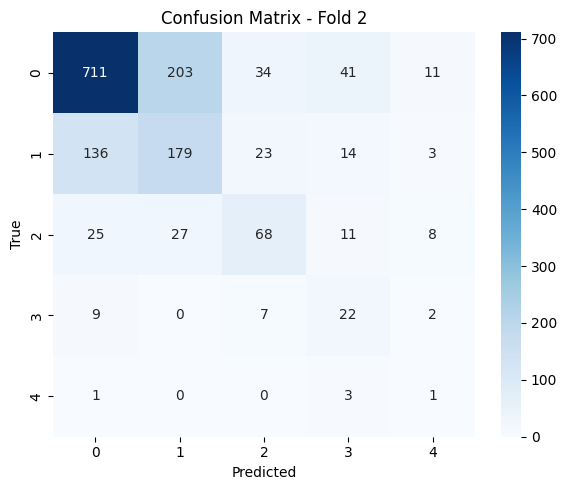

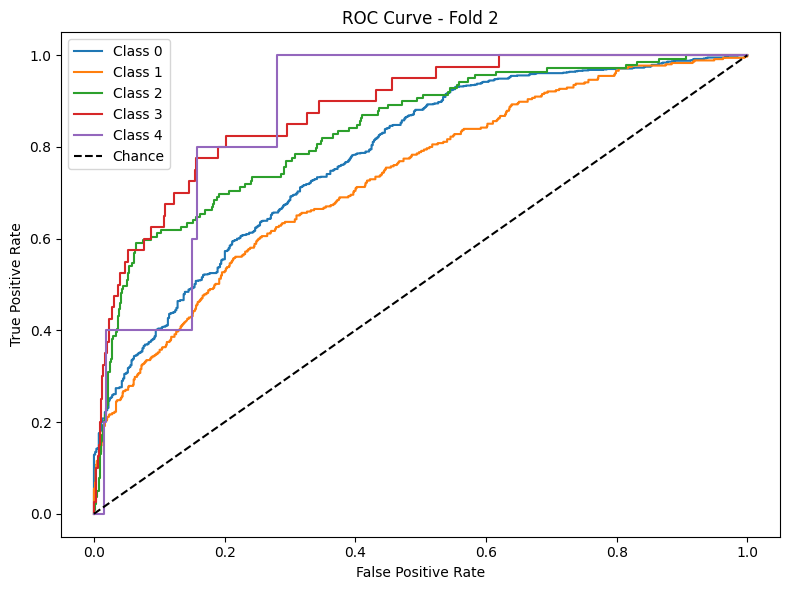

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


553/553 - 14s - 25ms/step - accuracy: 0.5102 - loss: 1.0573 - val_accuracy: 0.4172 - val_loss: 1.1446
Epoch 2/30
553/553 - 3s - 6ms/step - accuracy: 0.6820 - loss: 0.7771 - val_accuracy: 0.6049 - val_loss: 1.0026
Epoch 3/30
553/553 - 3s - 6ms/step - accuracy: 0.7335 - loss: 0.7098 - val_accuracy: 0.6212 - val_loss: 0.9993
Epoch 4/30
553/553 - 3s - 6ms/step - accuracy: 0.7426 - loss: 0.6789 - val_accuracy: 0.6231 - val_loss: 0.9396
Epoch 5/30
553/553 - 3s - 6ms/step - accuracy: 0.7520 - loss: 0.6642 - val_accuracy: 0.6322 - val_loss: 0.9513
Epoch 6/30
553/553 - 4s - 7ms/step - accuracy: 0.7589 - loss: 0.6414 - val_accuracy: 0.6374 - val_loss: 0.9386
Epoch 7/30
553/553 - 3s - 6ms/step - accuracy: 0.7642 - loss: 0.6257 - val_accuracy: 0.6205 - val_loss: 0.9198
Epoch 8/30
553/553 - 3s - 6ms/step - accuracy: 0.7643 - loss: 0.6264 - val_accuracy: 0.6420 - val_loss: 0.9020
Epoch 9/30
553/553 - 3s - 6ms/step - accuracy: 0.7720 - loss: 0.6109 - val_accuracy: 0.6420 - val_loss: 0.8988
Epoch 10/3

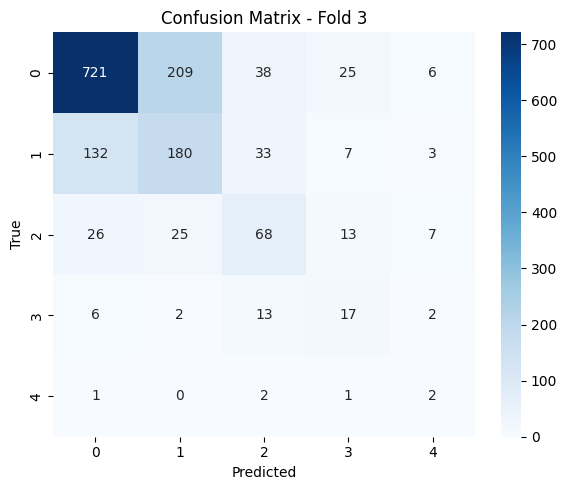

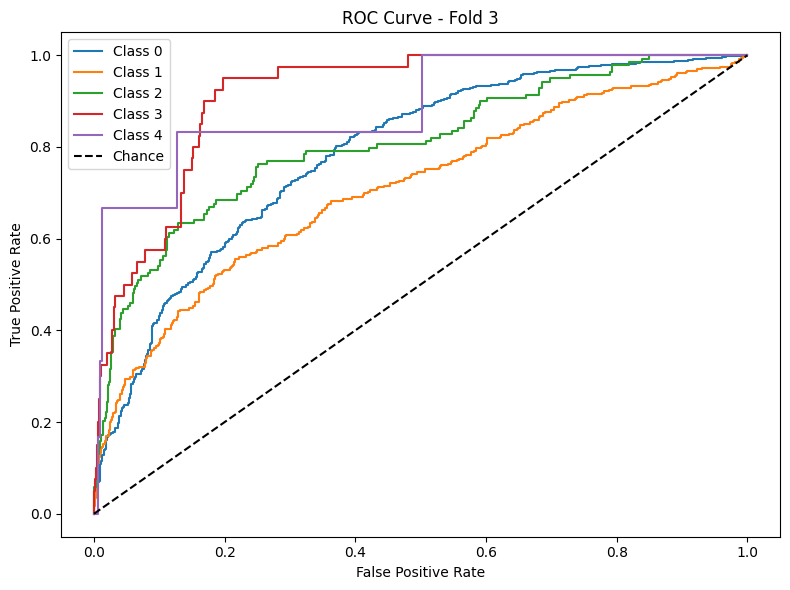

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


553/553 - 18s - 32ms/step - accuracy: 0.5599 - loss: 1.0076 - val_accuracy: 0.4337 - val_loss: 1.0751
Epoch 2/30
553/553 - 3s - 6ms/step - accuracy: 0.7081 - loss: 0.7545 - val_accuracy: 0.6229 - val_loss: 0.9717
Epoch 3/30
553/553 - 3s - 6ms/step - accuracy: 0.7306 - loss: 0.7108 - val_accuracy: 0.6391 - val_loss: 0.9667
Epoch 4/30
553/553 - 3s - 6ms/step - accuracy: 0.7403 - loss: 0.6852 - val_accuracy: 0.6372 - val_loss: 0.9566
Epoch 5/30
553/553 - 4s - 6ms/step - accuracy: 0.7483 - loss: 0.6663 - val_accuracy: 0.6216 - val_loss: 0.9466
Epoch 6/30
553/553 - 4s - 6ms/step - accuracy: 0.7534 - loss: 0.6524 - val_accuracy: 0.6469 - val_loss: 0.8987
Epoch 7/30
553/553 - 3s - 6ms/step - accuracy: 0.7568 - loss: 0.6381 - val_accuracy: 0.6287 - val_loss: 0.9218
Epoch 8/30
553/553 - 3s - 6ms/step - accuracy: 0.7639 - loss: 0.6227 - val_accuracy: 0.6398 - val_loss: 0.9117
Epoch 9/30
553/553 - 3s - 6ms/step - accuracy: 0.7638 - loss: 0.6171 - val_accuracy: 0.6573 - val_loss: 0.9058
Epoch 10/3

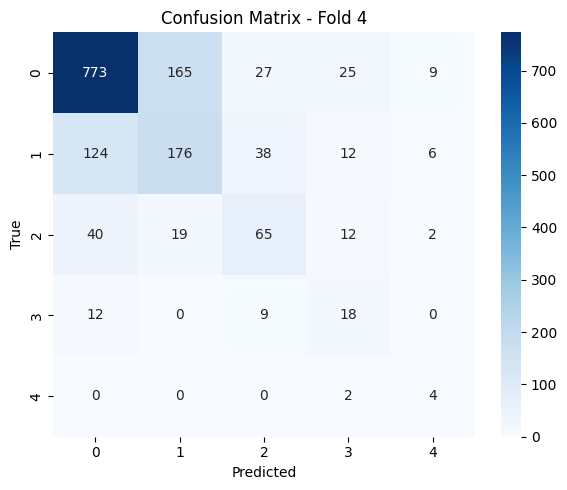

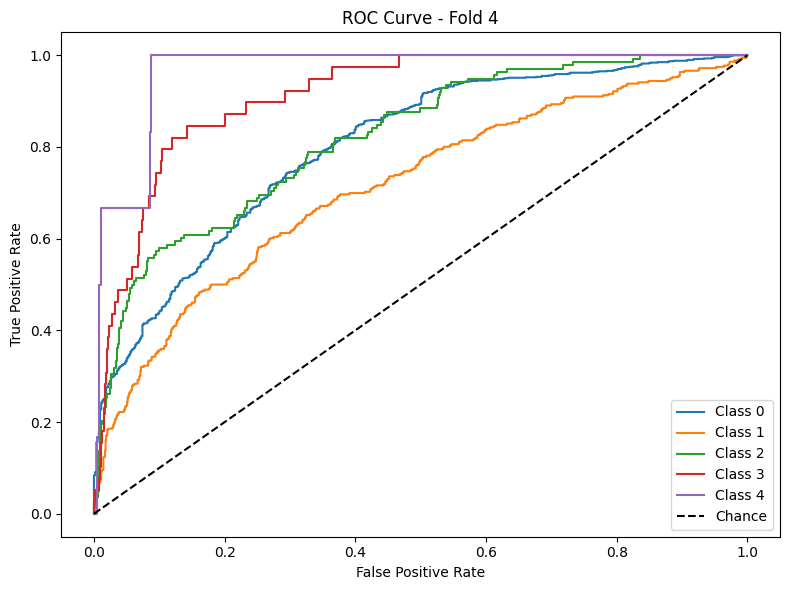

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


553/553 - 14s - 25ms/step - accuracy: 0.5498 - loss: 1.0217 - val_accuracy: 0.5644 - val_loss: 1.0758
Epoch 2/30
553/553 - 4s - 6ms/step - accuracy: 0.7021 - loss: 0.7631 - val_accuracy: 0.6079 - val_loss: 1.0041
Epoch 3/30
553/553 - 3s - 6ms/step - accuracy: 0.7299 - loss: 0.7087 - val_accuracy: 0.6261 - val_loss: 0.9947
Epoch 4/30
553/553 - 3s - 6ms/step - accuracy: 0.7390 - loss: 0.6826 - val_accuracy: 0.6125 - val_loss: 0.9612
Epoch 5/30
553/553 - 3s - 6ms/step - accuracy: 0.7483 - loss: 0.6615 - val_accuracy: 0.6040 - val_loss: 0.9788
Epoch 6/30
553/553 - 3s - 6ms/step - accuracy: 0.7535 - loss: 0.6466 - val_accuracy: 0.6307 - val_loss: 0.9528
Epoch 7/30
553/553 - 3s - 6ms/step - accuracy: 0.7585 - loss: 0.6281 - val_accuracy: 0.6235 - val_loss: 0.9544
Epoch 8/30
553/553 - 3s - 6ms/step - accuracy: 0.7607 - loss: 0.6238 - val_accuracy: 0.6164 - val_loss: 0.9613
Epoch 9/30
553/553 - 3s - 6ms/step - accuracy: 0.7668 - loss: 0.6135 - val_accuracy: 0.6463 - val_loss: 0.9282
Epoch 10/3

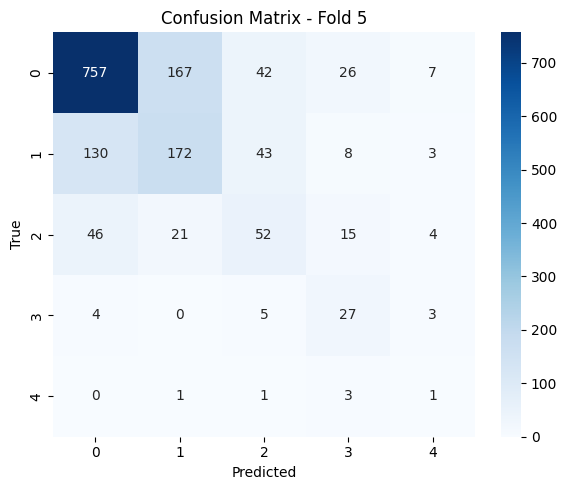

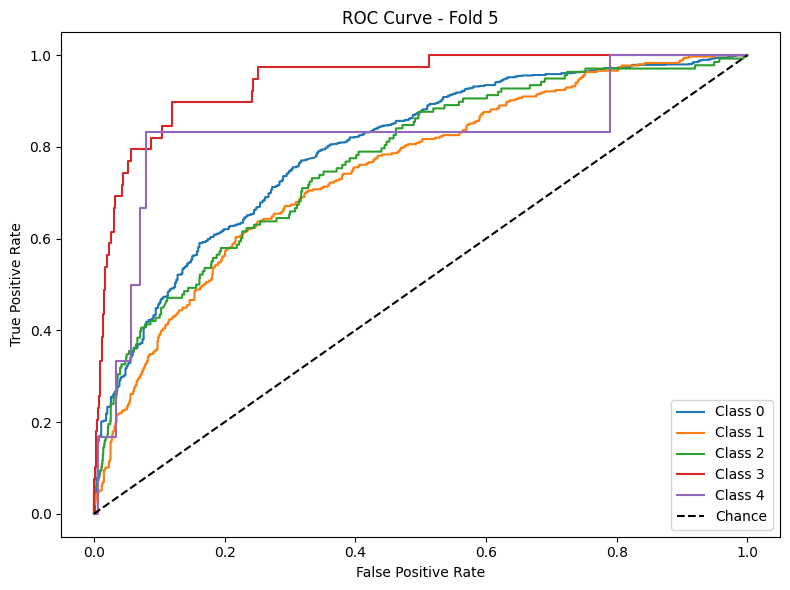


Average Accuracy: 0.6458
Average F1 Macro: 0.4339
Average AUC: 0.8218


In [8]:
# phase_paths = [f"/kaggle/input/smotesvm-enriched-data-with-node2vec/outputs/phase{i}" for i in range(1, 5)]
# results = {}

# for i, phase_path in enumerate(phase_paths, start=1):
#     print(f"\n=== Training Phase {i} ===")
#     sample = True
#     model, scaler, best_fold, metrics = train_phase(phase_path, sample = sample)
#     # Save best model & scaler
#     if sample: 
#         temp = "sample"
#     else: temp = "no_sample"
#     joblib.dump(model, f"best_model_{temp}_phase{i}.pkl")
#     joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")
#     results[f"phase{i}"] = metrics


phase_paths = [f"/kaggle/input/smotesvm-enriched-data-with-node2vec/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n=== Training Phase {i} ===")
    sample = True
    model, scaler, best_fold, metrics = train_phase(phase_path, sample=sample)

    temp = "sample" if sample else "no_sample"

    # ✅ Lưu model Keras
    model.save(f"best_model_{temp}_phase{i}.h5")

    # ✅ Lưu scaler sklearn
    joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")

    results[f"phase{i}"] = metrics


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step 

Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.92      0.90       568
           1       0.30      0.35      0.32        63
           2       0.31      0.23      0.27        43
           3       0.25      0.13      0.17        15
           4       0.00      0.00      0.00         9

    accuracy                           0.79       698
   macro avg       0.35      0.33      0.33       698
weighted avg       0.78      0.79      0.78       698



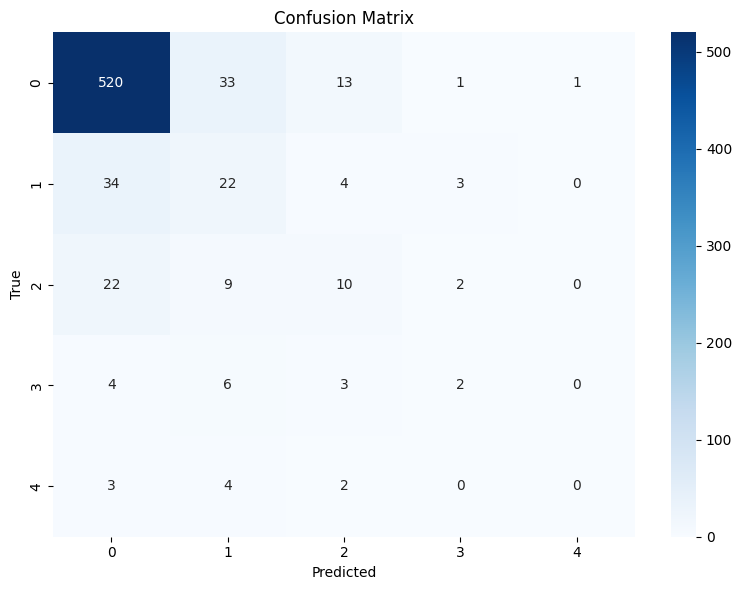


Test AUC (macro-average, OVR): 0.6388


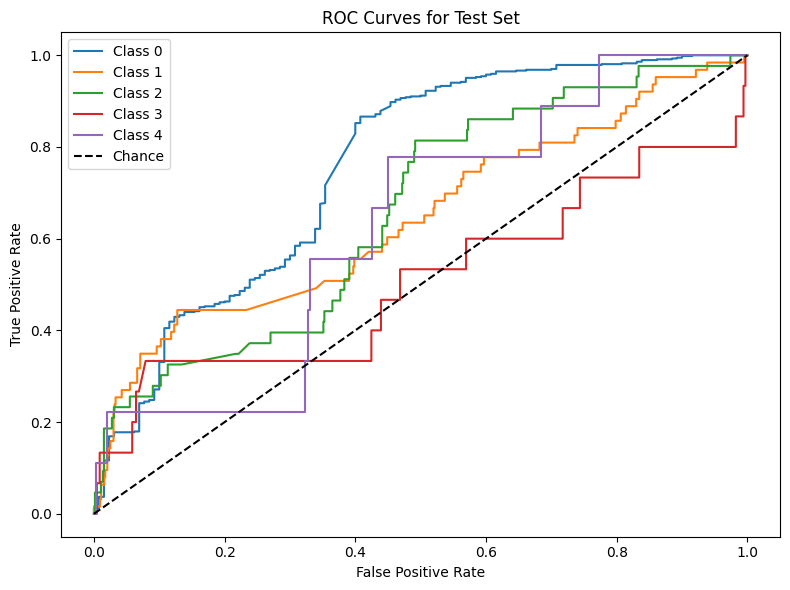

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step 

Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.91      0.90       544
           1       0.18      0.19      0.18        59
           2       0.25      0.33      0.29        42
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00         9

    accuracy                           0.78       668
   macro avg       0.27      0.29      0.27       668
weighted avg       0.76      0.78      0.77       668



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


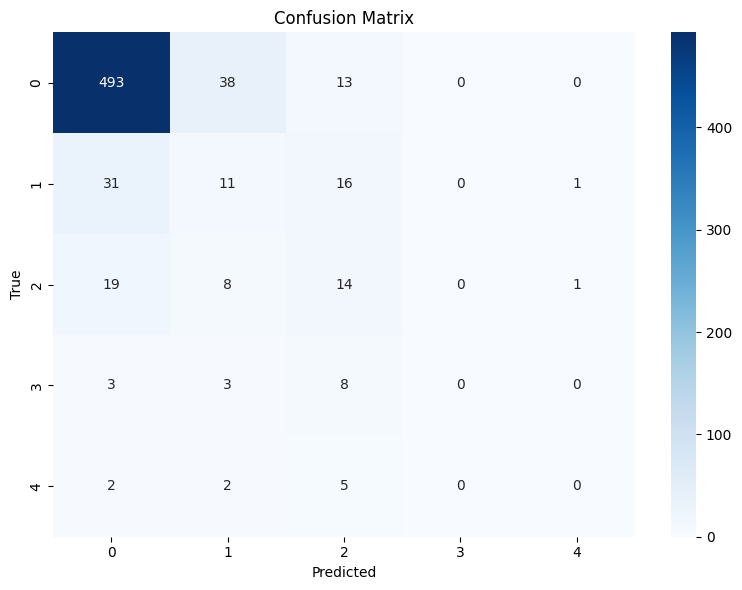


Test AUC (macro-average, OVR): 0.7279


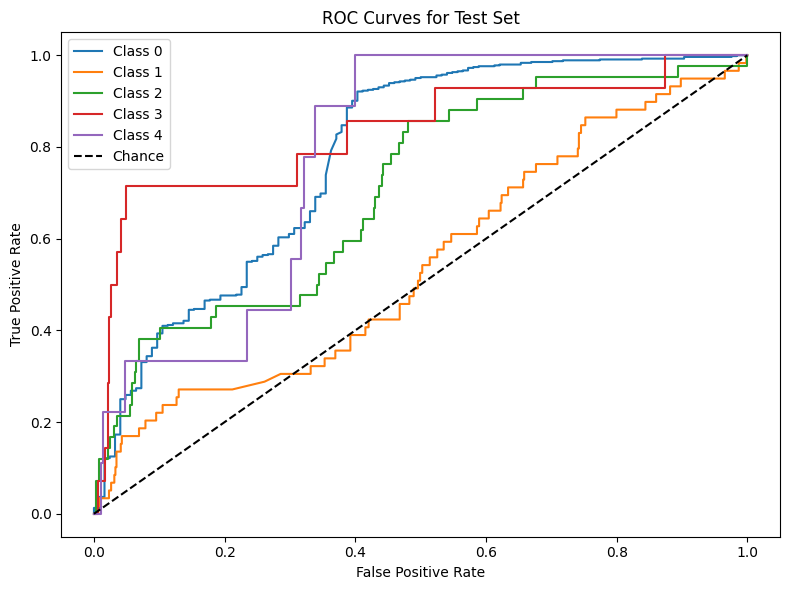

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step 

Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       455
           1       0.21      0.25      0.23        52
           2       0.26      0.28      0.27        29
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.77       554
   macro avg       0.27      0.28      0.28       554
weighted avg       0.76      0.77      0.76       554



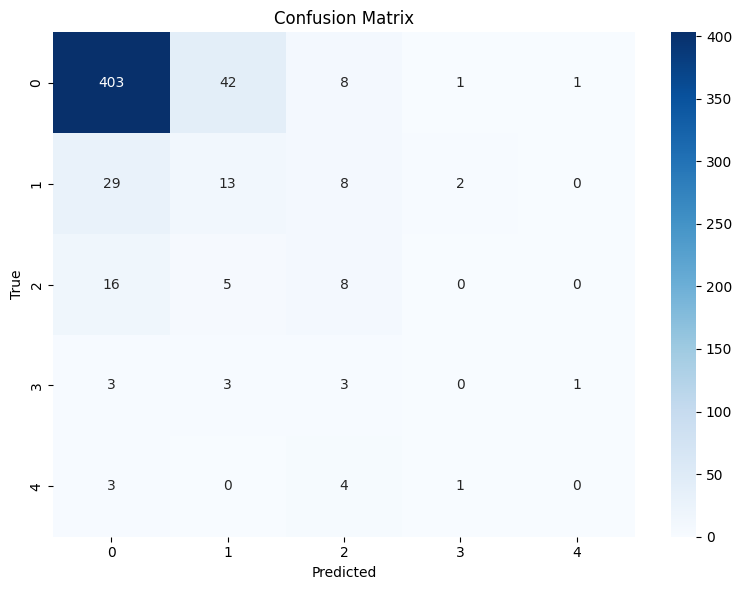


Test AUC (macro-average, OVR): 0.5999


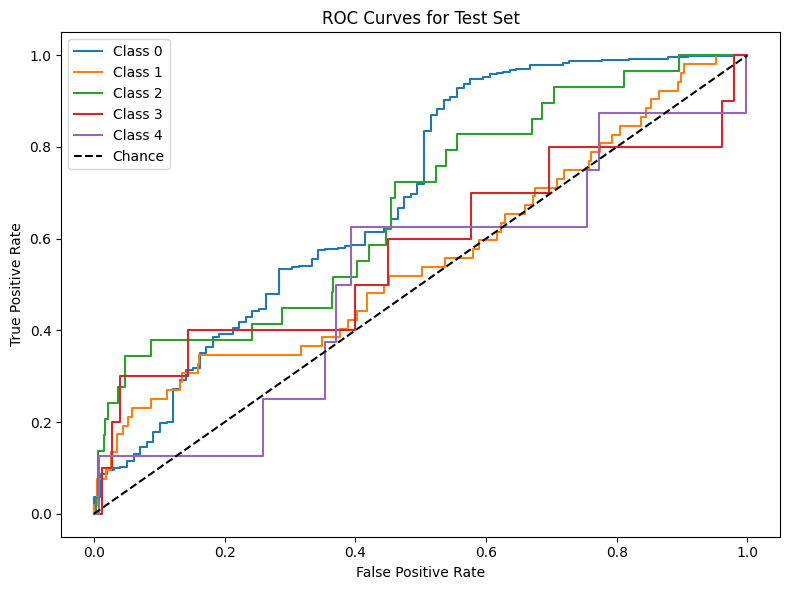

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step 

Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.64      0.75       395
           1       0.08      0.33      0.13        40
           2       0.18      0.29      0.22        24
           3       0.00      0.00      0.00        10
           4       0.33      0.12      0.18         8

    accuracy                           0.57       477
   macro avg       0.30      0.28      0.26       477
weighted avg       0.76      0.57      0.64       477



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


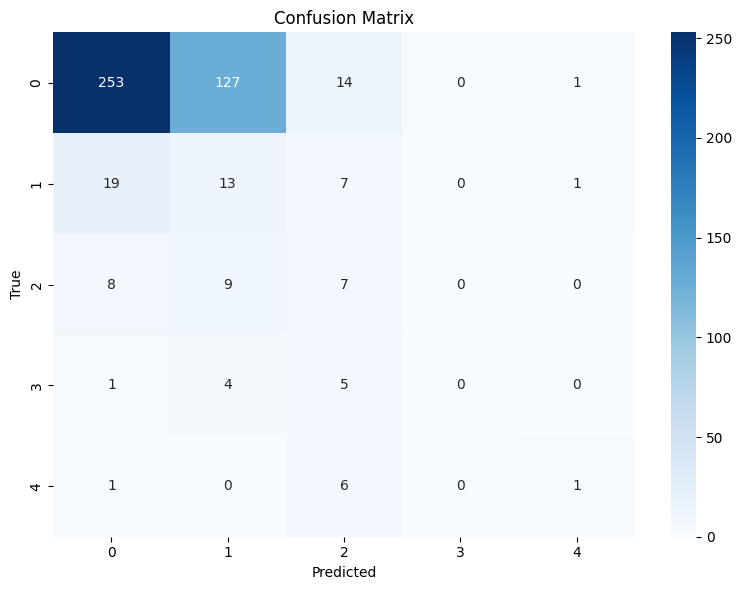


Test AUC (macro-average, OVR): 0.6314


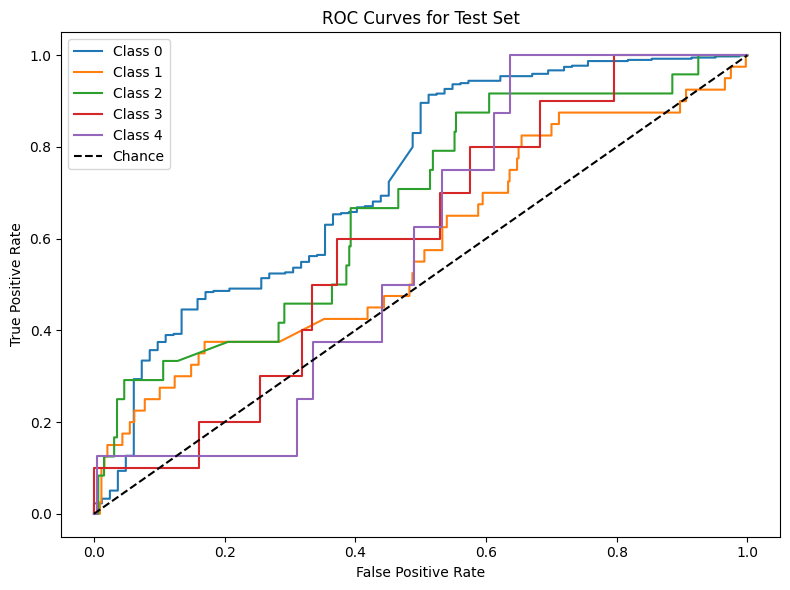

In [9]:
import glob

# for i in range(1, 5):
#     test_dir = f'/kaggle/input/enrich-data-using-node2vector/phase{i}/user_train_phase_{i}_test.csv'
    
#     # Get model and scaler using glob
#     model_path = f'/kaggle/working/best_model_{temp}_phase{i}.pkl'
#     scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
#     # School mapping path
#     school_mapping_file = f'/kaggle/input/smotesvm-enriched-data-with-node2vec/outputs/phase{i}/mappings/school_mapping.pkl'

#     # Predict on test set
#     predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)



from tensorflow.keras.models import load_model  # đảm bảo đã import đúng ở nơi dùng

# temp = "sample"  # hoặc "no_sample" — giống lúc bạn lưu model

for i in range(1, 5):
    test_dir = f'/kaggle/input/enrich-data-using-node2vector/phase{i}/user_train_phase_{i}_test.csv'

    # ✅ Đường dẫn đúng cho mô hình Keras .h5
    model_path = f'/kaggle/working/best_model_{temp}_phase{i}.h5'
    scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'

    # ✅ Đường dẫn mapping
    school_mapping_file = f'/kaggle/input/smotesvm-enriched-data-with-node2vec/outputs/phase{i}/mappings/school_mapping.pkl'

    # ✅ Gọi hàm dự đoán đã tương thích với LSTM
    predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)